<a href="https://colab.research.google.com/github/sdesena/above-ground-biomass/blob/main/TCC_Sandro_De_Sena_Machado_MBA_DSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Install and import libraries

In [ ]:
# !pip install earthengine-api

# Install libraries
!pip install rasterio -q
!pip install earthpy -q

# for Earth Engine API
import ee
import geemap
import json

# for general use
import geopandas as gpd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import rasterio  # Rasterio é usado para ler, escrever e manipular dados raster (dados de imagem geoespacial).
from rasterio.plot import show
import earthpy.plot as ep  # 'earthpy.plot' é uma sub-biblioteca de EarthPy usada para plotar dados geoespaciais, especialmente útil para visualizar imagens de sensoriamento remoto.

# for model fitting
from sklearn.model_selection import KFold # Cross-validation
from sklearn.model_selection import train_test_split  # 'train_test_split' é usado para dividir arrays ou matrizes em subconjuntos aleatórios de dados de treino e teste.
from sklearn.ensemble import RandomForestRegressor
import keras  # Keras é uma biblioteca de redes neurais de alto nível que roda sobre TensorFlow, Theano ou CNTK. É usada para construir e treinar modelos de aprendizado profundo.
from keras import Sequential  # 'Sequential' do Keras é um modelo linear que é uma pilha de camadas. É usado para criar modelos onde cada camada tem exatamente um tensor de entrada e um tensor de saída.
from keras.layers import Dense, Dropout, Input  # 'Dense' é uma camada de rede neural totalmente conectada. 'Dropout' é usada para reduzir o overfitting. 'Input' é usado para definir a entrada do modelo.
from keras.callbacks import EarlyStopping  # 'EarlyStopping' é uma técnica de regularização usada para parar o treinamento assim que o desempenho do modelo para de melhorar em um conjunto de validação.
from keras import Model  # 'Model' do Keras é uma classe usada para construir um modelo de aprendizado profundo com mais flexibilidade. Permite criar modelos com múltiplas entradas e saídas.
from keras.utils import to_categorical, plot_model  # 'to_categorical' é usado para converter vetores de inteiros em uma representação binária. 'plot_model' é usado para visualizar redes neurais.


# for accuracy assesment
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score  # 'mean_squared_error' e 'r2_score' do scikit-learn são usados para avaliar o desempenho de modelos de regressão.

# for model explanation
import sys
!{sys.executable} -m pip install shap
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 14.1 MB/s eta 0:00:00


In [ ]:
# Authenticate and initialize Google cloud project
ee.Authenticate()
ee.Initialize(project='ee-sandrosenamachado')

In [ ]:
# Set up Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Area Of Interest (AOI)

A escolha da Terra Indígena Mangueirinha como área de estudo se deu em função da qualidade, regularidade e relevância dos dados disponíveis de AGB coletados em campo, bem como à representatividade da amostragem e às parcerias estabelecidas para a coleta e análise desses dados. Assim, obtém-se um conjunto de referência (Ground Truth) para o ano de 2015 para posterior calibração e validação dos modelos.

A Terra Indígena Mangueirinha, situada na região oeste do Paraná, na bacia do Rio Iguaçu, é apresentada no relatório técnico do Inventário Florestal Nacional (IFN), a partir de dados acerca da saúde e vitalidade das florestas, biodiversidade, quantitativos de biomassa e carbono em estoque, bem como dados socioambientais.


In [ ]:
# Load shapefile data
gdf = gpd.read_file('/content/drive/MyDrive/Geoprocessamento/GIS Data/Terras indígenas/dashboard_indigenous-lands-static-layer.shp')

# Check data structure and dimensions
gdf.head()

,id,version,name,source,inserted_a,updated_at,category,category_n,area_ha,geometry
0,12618,1,Mato Castelhano,FUNAI,2020-02-07,2020-02-07,indigenous_land,Terra Indígena,3569.67303,"POLYGON ((-52.17715 -28.34522, -52.17723 -28.3..."
1,12619,1,Mato Preto,FUNAI,2020-02-07,2020-02-07,indigenous_land,Terra Indígena,4232.18007,"POLYGON ((-52.25868 -27.78328, -52.18658 -27.7..."
2,12620,1,Mawetek,FUNAI,2020-02-07,2020-02-07,indigenous_land,Terra Indígena,115527.67786,"POLYGON ((-69.99875 -6.70515, -69.99985 -6.703..."
3,14270,1,Cachoeira dos InOcios,FUNAI,2020-02-07,2020-02-07,indigenous_land,Terra Indígena,81.38464,"POLYGON ((-48.80004 -28.17988, -48.79770 -28.1..."
4,14275,1,Cachoeira Seca,FUNAI,2020-02-07,2020-02-07,indigenous_land,Terra Indígena,732447.51518,"POLYGON ((-53.40379 -3.90833, -53.40417 -3.909..."


,id,name,area_ha,geometry
396,15117,Mangueirinha,17246.73911,"POLYGON ((-52.28217 -25.79600, -52.28207 -25.7..."


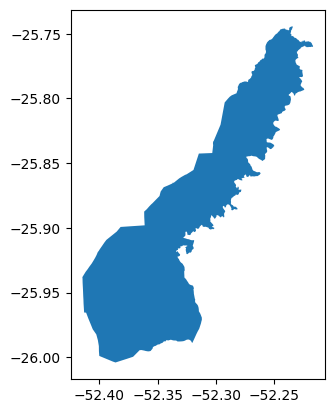

In [ ]:
# Select relevant features
gdf = gdf[['id','name','area_ha','geometry']]

# Filter features per attribute
aoi_shp = gdf[gdf['name']=='Mangueirinha']

# Plot the shape
aoi_shp.plot()

# Check attributes
aoi_shp.head()


In [ ]:
# Transform shapefile to JSON
shp_json = aoi_shp.to_json()

# Load JSON file
aoi = json.loads(shp_json)

# Select features
aoi = aoi['features']

# Check the process
aoi

<ipython-input-6-e41afdcf7fbc>:2: UserWarning: GeoDataFrame's CRS is not representable in URN OGC format. Resulting JSON will contain no CRS information.
  shp_json = aoi_shp.to_json()


[{'id': '396',
  'type': 'Feature',
  'properties': {'id': 15117, 'name': 'Mangueirinha', 'area_ha': 17246.73911},
  'geometry': {'type': 'Polygon',
   'coordinates': [[[-52.2821692713, -25.7959960315],
     [-52.2820723001, -25.7955308774],
     [-52.2817599915, -25.794678151],
     [-52.2813292431, -25.7937770115],
     [-52.281027699, -25.7928951704],
     [-52.2810276063, -25.7921779022],
     [-52.28114598609999, -25.7916446614],
     [-52.2811459391, -25.7910919985],
     [-52.2806505534, -25.7902584312],
     [-52.2803920729, -25.7896089757],
     [-52.2799827763, -25.7888819822],
     [-52.2793689468, -25.7883198184],
     [-52.27864746609999, -25.78788371310001],
     [-52.2782598664, -25.78788377640001],
     [-52.27791531569999, -25.7878353443],
     [-52.2776137838, -25.7876124061],
     [-52.27735532559999, -25.7874185501],
     [-52.276999991, -25.7873507382],
     [-52.2767092782, -25.787379859],
     [-52.2763754467, -25.7872247803],
     [-52.2760523695, -25.7870696829

In [ ]:
# Create a feature collection with the JSON
region = ee.FeatureCollection(aoi)

In [ ]:
# # Saving the JSON and SHP file
# gdf.to_file("aoi.json", driver='GeoJSON')
# gdf.to_file("aoi.shp")

In [ ]:
# json_file_path ='/content/aoi.json'
# with open(json_file_path, 'r') as json_file_path:
#      contents = json.loads(json_file_path.read())


In [ ]:
# # selecionando as features
# nova_roi = contents['features']
# # Verificando o processo
# nova_roi


In [ ]:
##Adicionando a feature  = Converte para Image (desenha o limite)

# Mapa
Map = geemap.Map()

# Draw AOI contour
image_region = ee.Image().paint(region, 0, 2)

# Add layer
Map.addLayer(image_region,{'palette':'red'}, 'AOI')

# Centralize AOI
Map.centerObject(region,10)

# Set basemap
Map.set_options('HYBRID')

# Call Map funciton
Map

Map(center=[-25.893377156799872, -52.325960071094045], controls=(WidgetControl(options=['position', 'transpare…

## Exploratory Data Analysis



In [ ]:
##Defindo a coleção de imagem  - acessar o asset de dados no Google Earth Engine: ID: projects/mapbiomas-workspace/public/collection7/mapbiomas_collection70_integration_v2
path_project = 'projects/mapbiomas-workspace/public/collection7/mapbiomas_collection70_integration_v2'

##Define a imagem collection
mapbiomas = ee.Image(path_project)
print('Dados MapBiomas',mapbiomas.bandNames().getInfo())

Dados MapBiomas ['classification_1985', 'classification_1986', 'classification_1987', 'classification_1988', 'classification_1989', 'classification_1990', 'classification_1991', 'classification_1992', 'classification_1993', 'classification_1994', 'classification_1995', 'classification_1996', 'classification_1997', 'classification_1998', 'classification_1999', 'classification_2000', 'classification_2001', 'classification_2002', 'classification_2003', 'classification_2004', 'classification_2005', 'classification_2006', 'classification_2007', 'classification_2008', 'classification_2009', 'classification_2010', 'classification_2011', 'classification_2012', 'classification_2013', 'classification_2014', 'classification_2015', 'classification_2016', 'classification_2017', 'classification_2018', 'classification_2019', 'classification_2020', 'classification_2021']


In [ ]:
##Palette MapBiomas - https://mapbiomas-br-site.s3.amazonaws.com/downloads/_EN__C%C3%B3digos_da_legenda_Cole%C3%A7%C3%A3o_7.pdf
palette_list = ['#ffffff','#129912','#1f4423','#006400','#00ff00','#687537','#76a5af','#29eee4',
'#77a605','#ad4413','#bbfcac','#45c2a5','#b8af4f','#f1c232','#ffffb2','#ffd966',
'#f6b26b','#f99f40','#e974ed','#d5a6bd','#c27ba0','#fff3bf','#ea9999','#dd7e6b',
'#aa0000','#ff8585','#0000ff','#d5d5e5','#dd497f','#665a3a','#ff0000','#1f0478',
'#968c46','#0000ff','#4fd3ff','#ba6a27','#f3b4f1','#02106f','#02106f','#e075ad',
'#982c9e','#e787f8','#ebebe0','#c2c2a3','#6b6b47','#d0ffd0','#cca0d4','#d082de',
'#cd49e4','#6b9932','#66ffcc','#000000','#000000','#000000','#000000','#000000',
'#000000','#CC66FF','#FF6666','#006400','#8d9e8b','#84ff75','#faf87d']

In [ ]:
# Mapbiomas layer
map_1985 = mapbiomas.select('classification_1985')
map_2021 = mapbiomas.select('classification_2021')

# show
Map.addLayer(map_1985, {'palette':palette_list, 'min':0, 'max':62},'1985')
Map.addLayer(map_2021, {'palette':palette_list, 'min':0, 'max':62},'2021')

Map

Map(center=[-25.893377156799872, -52.325960071094045], controls=(WidgetControl(options=['position', 'transpare…

In [ ]:
##Recortando nossa base para a região de interesse
reg_1985 = map_1985.clip(region)
reg_2021 = map_2021.clip(region)

In [ ]:
##Visualizando dados do MapBiomas
Map.addLayer(reg_1985,{'palette':palette_list, 'min':0,'max':62},'Mangueirinha 1985')
Map.addLayer(reg_2021,{'palette':palette_list, 'min':0,'max':62},'Mangueirinha 2021')

# show
Map

Map(center=[-25.893377156799872, -52.325960071094045], controls=(WidgetControl(options=['position', 'transpare…

In [ ]:
##Cálculo de área  fonte: https://mapbiomas-br-site.s3.amazonaws.com/downloads/_EN__C%C3%B3digos_da_legenda_Cole%C3%A7%C3%A3o_7.pdf
Urban_Area= 24
Forest = 1

##Loop para criar uma image collection a partir das bandas o Mapbiomas
lista = ee.List.sequence(0, 36)
years = ee.List.sequence(1985, 2021)

##Função
def collection_image(number):
  matchKey = ee.String(ee.List(mapbiomas.bandNames()).get(number))##vamos selecionar
                                                                    ##o valor da lista das bandas

  # urban = ee.Image(mapbiomas).select(matchKey).eq(Urban_Area).selfMask().rename('urban');##selcionando apenas a classe de interesse
  # forest = ee.Image(mapbiomas).select(matchKey).eq(Forest).selfMask().rename('forest');##selcionando apenas a classe de interesse

  image = ee.Image(mapbiomas).select(matchKey)
  return image.set('year', years.get(number))\
               .set('system:time_start', ee.Date.fromYMD(years.get(number), 1, 1))\
                .clip(region)

##Aplicando a função sobre a lista
listImages = lista.map(collection_image)

##Criando nossa coleção de imagens
imageCollection = ee.ImageCollection.fromImages(listImages)
print('Coleção de imagens',imageCollection.size().getInfo())

Coleção de imagens 37


In [ ]:
##Verificando as bandas
imageCollection.first().bandNames()

In [ ]:
##Quantas imagens
count = imageCollection.size().getInfo()
year_list = years.getInfo()
lista_list= lista.getInfo()

In [ ]:
### Inserção do nome da classe
dicionario_classes = {
    0:"Fora da área de interesse", 1:"Floresta", 3:"Formação Florestal",
    4:"Formação Savânica", 5:"Mangue", 49:"Restinga Arborizada",  10:"Formação Natural não Florestal",
    11:"Campo Alagado e Área Pantanosa",   12:"Formação Campestre",
    32:"Apicum",   29:"Afloramento Rochoso",   50:"Restinga Herbácea",
    13:"Outras Formações não Florestais",  14:"Agropecuária",
    15:"Pastagem",   18:"Agricultura",
    19:"Lavoura Temporária",   39:"Soja",
    20:"Cana",   40:"Arroz (beta)",   62:"Algodão (beta)",
    41:"Outras Lavouras Temporárias", 36:"Lavoura Perene",  46:"Café",
    47:"Citrus",  48:"Outras Lavouras Perenes",  9:"Silvicultura",
    21:"Mosaico de Usos",  22:"Área não Vegetada",  23:"Praia, Duna e Areal",
    24:"Área Urbanizada",  30:"Mineração", 25:"Outras Áreas não Vegetadas",
    26:"Corpo D'água", 33:"Rio, Lago e Oceano",
    31:"Aquicultura", 27:"Não observado"
}

### Inserção das cores de legenda
dicionario_cores = {
    0:"white", 1:"#129912",
    3:"#006400", 4:"#00ff00",
    5:"#687537", 49:"#6b9932",
    10:"#bbfcac", 11:"#45c2a5",
    12:"#b8af4f", 32:"#968c46",
    29:"#ff8C00", 50:"#66ffcc",
    13:"#bdb76b",
    14:"#ffffb2",
    15:"#ffd966",
    18:"#e974ed",
    19:"#d5a6bd",
    39:"#c59ff4",
    20:"#c27ba0",
    40:"#982c9e",
    62:"#660066",
    41:"#e787f8",
    36:"#f3b4f1",
    46:"#cca0d4",
    47:"#d082de",
    48:"#cd49e4",
    9:"#935132",
    21:"#fff3bf",
    22:"#ea9999",
    23:"#dd7e6b",
    24:"#af2a2a",
    30:"#8a2be2",
    25:"#ff99ff",
    26:"#0000ff",
    33:"#0000ff",
    31:"#29eee4",
    27:"#D5D5E5"
}

## paleta
paleta_nomes = {key:value for key, value in zip(dicionario_classes.values(), dicionario_cores.values())}

In [ ]:
##Abrindo todas as imagens
##Calcular a área para todas as imagens
# Crie uma lista vazia
df = []

##Calcular a área e gera o dataframe
for i in range(0,count,5): ######################ALTEREI PARA 5 ANOS#################################
    image = ee.Image((listImages).get(i))

    ##Calculo de área dos pixels de classificação
    areaImage = ee.Image.pixelArea().divide(1e6).addBands(image);

    ##Agrupando valores
    areas = areaImage.reduceRegion(**{
    ##Agrupa os registros do redutor pelo valor de uma determinada entrada e reduz
    ##cada grupo com o redutor fornecido.
      'reducer': ee.Reducer.sum().group(**{
      'groupField': 1,
      'groupName': 'classification'+'_'+str(year_list[i]),
    }),
    'geometry': region,
    'scale': 30,
    'bestEffort': True,
    'maxPixels': 1e13
    })

    # Criando uma lista para extrair o valor da área
    lista = areas.get('groups').getInfo()

    # Transformando a lista em Dataframe
    area_df = pd.DataFrame(lista, columns=['classification'+'_'+str(year_list[i]),'sum'])

    ##Adicionando uma coluna com o ano
    area_df['ano'] = int(year_list[i])
    ##Area_km2 =
    area_df['area'] = area_df['sum'].round(2)
    # Adicionando uma coluna com número da classe para renomear de acordo com o dicionário
    area_df['classe'] = area_df['classification_'+str(year_list[i])]
    ##Renomeando considerando o lugar
    area_df['nome_classe']= area_df['classe'].replace(dicionario_classes)
    ##Removendo colunas
    area_df = area_df.drop(columns=['classification_'+str(year_list[i]),'sum'], axis = 1)

    ##Juntado o DataFrame com a lista vazia criada
    df.append(area_df)

In [ ]:
## cria um dataframe completo
df_completo = pd.concat(df, axis = 'index')
df_completo.round(2).head()

,ano,area,classe,nome_classe
0,1985,133.55,3,Formação Florestal
1,1985,0.53,9,Silvicultura
2,1985,0.23,11,Campo Alagado e Área Pantanosa
3,1985,2.42,15,Pastagem
4,1985,33.47,21,Mosaico de Usos


In [ ]:
## criando coluna de classe e de área
df_melt = pd.melt(df_completo, id_vars=['ano','classe','nome_classe'],value_vars='area', value_name="Area_km_2",var_name='Área_classe').dropna()
df_melt.head()

,ano,classe,nome_classe,Área_classe,Area_km_2
0,1985,3,Formação Florestal,area,133.55
1,1985,9,Silvicultura,area,0.53
2,1985,11,Campo Alagado e Área Pantanosa,area,0.23
3,1985,15,Pastagem,area,2.42
4,1985,21,Mosaico de Usos,area,33.47


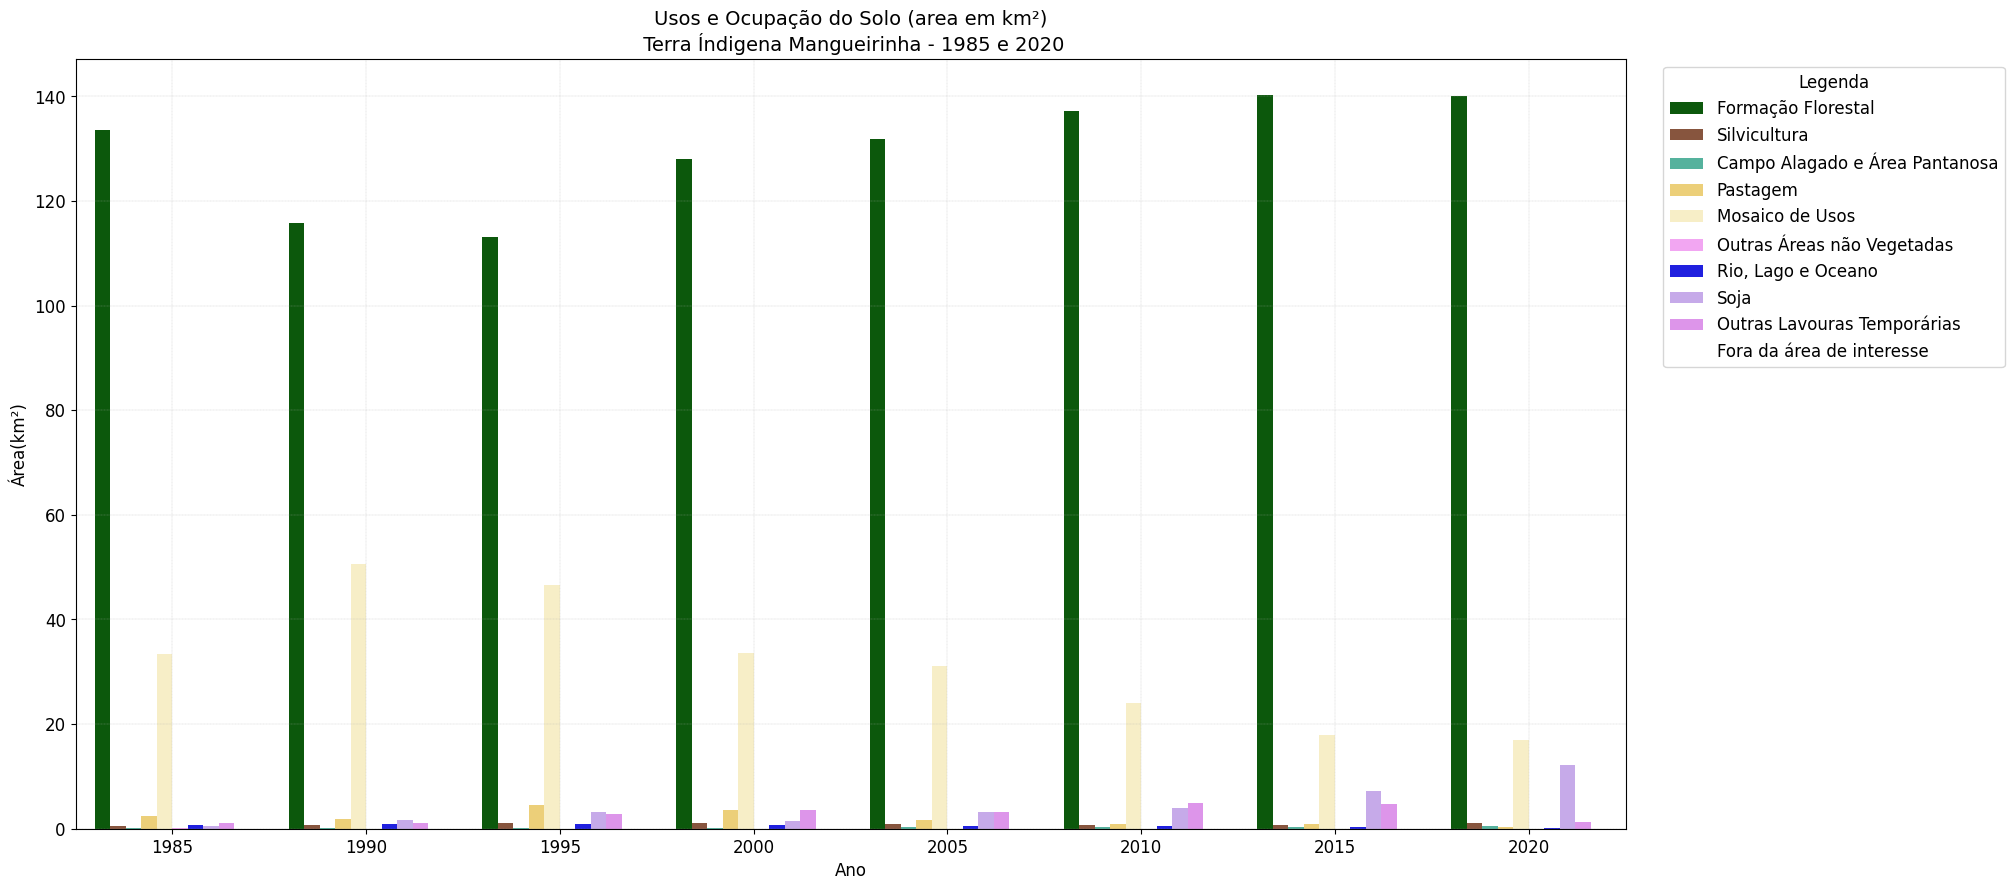

In [ ]:
## Plot geral - evolução do uso do solo
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(data=df_melt, x="ano", y="Area_km_2", hue="nome_classe", palette=paleta_nomes)

#Título
plt.title('Usos e Ocupação do Solo (area em km²)\n Terra Índigena Mangueirinha - 1985 e 2020', fontsize =14)

##eixo x
plt.xlabel('Ano',fontsize=12)
plt.xticks(fontsize=12)
##eixo y
plt.ylabel('Área(km²)',fontsize=12)
plt.yticks(fontsize=12)

##Personalizando o gráfico
plt.grid(linestyle='--', linewidth=0.2, which='both')
ax.legend(loc="upper right",bbox_to_anchor=(1.25, 1), title = "Legenda", title_fontsize = "12", fontsize='12')

In [ ]:
##Dataframe para soja
df_agro=df_melt[df_melt.nome_classe=='Soja']
df_agro

,ano,classe,nome_classe,Área_classe,Area_km_2
7,1985,39,Soja,area,0.47
16,1990,39,Soja,area,1.64
25,1995,39,Soja,area,3.25
34,2000,39,Soja,area,1.48
43,2005,39,Soja,area,3.11
52,2010,39,Soja,area,4.02
61,2015,39,Soja,area,7.29
69,2020,39,Soja,area,12.11


In [ ]:
##Selecionar apenas a classe formação florestal
df_veg=df_melt[df_melt.nome_classe=='Formação Florestal']
df_veg

,ano,classe,nome_classe,Área_classe,Area_km_2
0,1985,3,Formação Florestal,area,133.55
9,1990,3,Formação Florestal,area,115.77
19,1995,3,Formação Florestal,area,113.05
27,2000,3,Formação Florestal,area,128.11
36,2005,3,Formação Florestal,area,131.93
45,2010,3,Formação Florestal,area,137.15
54,2015,3,Formação Florestal,area,140.20
63,2020,3,Formação Florestal,area,140.04


In [ ]:
##Selecionar apenas a classe mosaico de usos
df_mosaico=df_melt[df_melt.nome_classe=='Mosaico de Usos']
df_mosaico

,ano,classe,nome_classe,Área_classe,Area_km_2
4,1985,21,Mosaico de Usos,area,33.47
13,1990,21,Mosaico de Usos,area,50.55
23,1995,21,Mosaico de Usos,area,46.53
31,2000,21,Mosaico de Usos,area,33.66
40,2005,21,Mosaico de Usos,area,31.11
49,2010,21,Mosaico de Usos,area,24.03
58,2015,21,Mosaico de Usos,area,17.84
67,2020,21,Mosaico de Usos,area,16.89


In [ ]:
##Selecionar apenas a classe mosaico de usos
df_silvicultura=df_melt[df_melt.nome_classe=='Silvicultura']
df_silvicultura

,ano,classe,nome_classe,Área_classe,Area_km_2
1,1985,9,Silvicultura,area,0.53
10,1990,9,Silvicultura,area,0.62
20,1995,9,Silvicultura,area,1.14
28,2000,9,Silvicultura,area,1.11
37,2005,9,Silvicultura,area,0.83
46,2010,9,Silvicultura,area,0.79
55,2015,9,Silvicultura,area,0.79
64,2020,9,Silvicultura,area,1.07


In [ ]:
##Selecionar apenas a classe mosaico de usos
df_Pastagem=df_melt[df_melt.nome_classe=='Pastagem']
df_Pastagem

,ano,classe,nome_classe,Área_classe,Area_km_2
3,1985,15,Pastagem,area,2.42
12,1990,15,Pastagem,area,1.77
22,1995,15,Pastagem,area,4.59
30,2000,15,Pastagem,area,3.62
39,2005,15,Pastagem,area,1.64
48,2010,15,Pastagem,area,0.85
57,2015,15,Pastagem,area,0.93
66,2020,15,Pastagem,area,0.42


In [ ]:
##Selecionar apenas a classe mosaico de usos
df_lavoura=df_melt[df_melt.nome_classe=='Outras Lavouras Temporárias']
df_lavoura

,ano,classe,nome_classe,Área_classe,Area_km_2
8,1985,41,Outras Lavouras Temporárias,area,1.07
17,1990,41,Outras Lavouras Temporárias,area,1.09
26,1995,41,Outras Lavouras Temporárias,area,2.87
35,2000,41,Outras Lavouras Temporárias,area,3.55
44,2005,41,Outras Lavouras Temporárias,area,3.13
53,2010,41,Outras Lavouras Temporárias,area,4.93
62,2015,41,Outras Lavouras Temporárias,area,4.73
70,2020,41,Outras Lavouras Temporárias,area,1.33


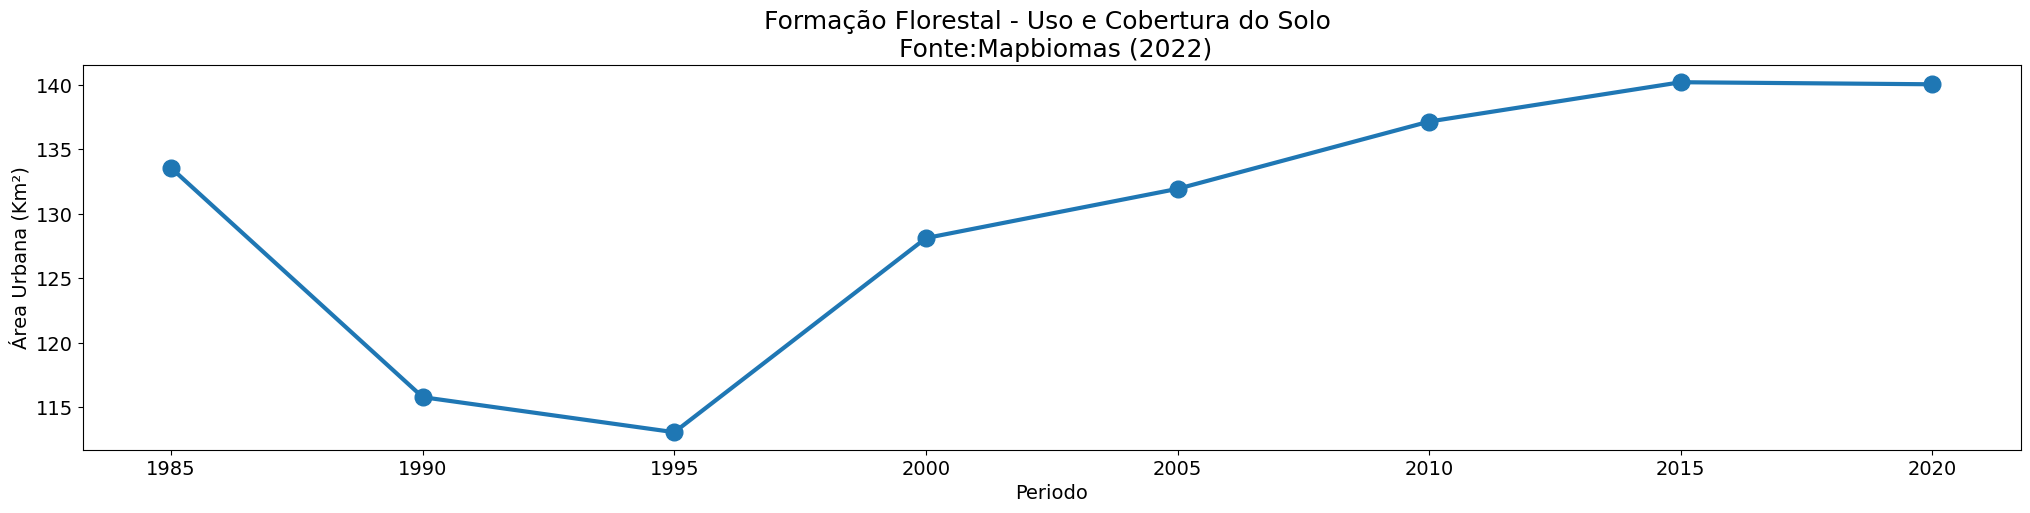

In [ ]:
##Definindo o tamando da figura
fig, ax = plt.subplots(figsize=(25,5))

##Definindo o x e o y da figura
x = df_veg['ano']
y = df_veg['Area_km_2']

#Título
plt.title('Formação Florestal - Uso e Cobertura do Solo \n Fonte:Mapbiomas (2022)', fontsize=18)

##Definir marcação
plt.plot(x, y, marker='o', linewidth=3, markersize=12) ##dados de área
##Eixo x
plt.xlabel('Periodo',fontsize=14)
plt.xticks(rotation=0,fontsize=14)

##Eixo Y
plt.ylabel('Área Urbana (Km²)',fontsize=14)
plt.yticks(fontsize=14)

plt.show()

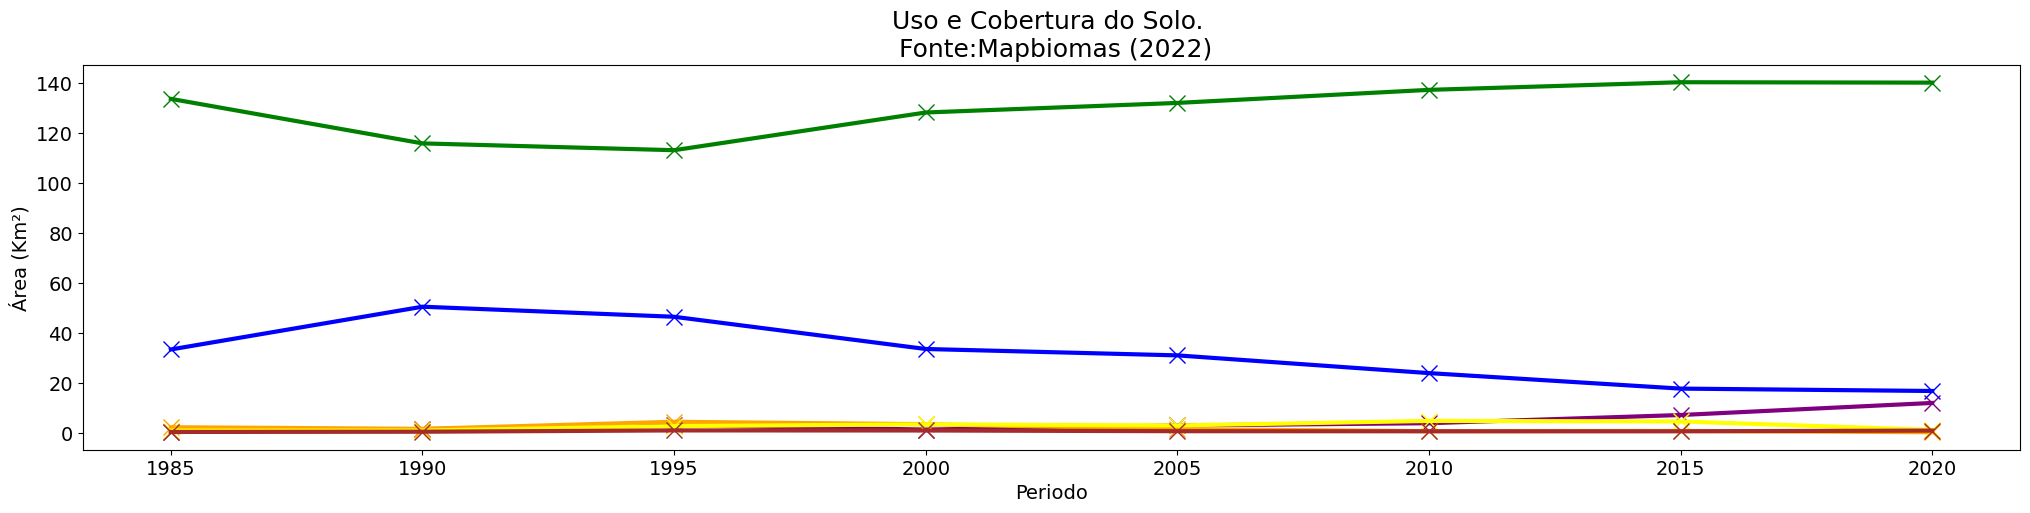

In [ ]:
##Definindo o tamando da figura
fig, ax = plt.subplots(figsize=(25,5))

##Definindo o x e o y da figura
x = df_veg['ano']
y = df_agro['Area_km_2']
y2 = df_Pastagem['Area_km_2']
y3 = df_lavoura['Area_km_2']
y4 = df_silvicultura['Area_km_2']
y5 = df_mosaico['Area_km_2']
y6 = df_veg['Area_km_2']

#Título
plt.title('Uso e Cobertura do Solo. \n Fonte:Mapbiomas (2022)', fontsize=18)

##Definir marcação
plt.plot(x, y, marker='x', linewidth=3, markersize=12, color='purple') ##dados de área
plt.plot(x, y2, marker='x', linewidth=3, markersize=12, color='orange') ##dados de área
plt.plot(x, y3, marker='x', linewidth=3, markersize=12, color='yellow') ##dados de área
plt.plot(x, y4, marker='x', linewidth=3, markersize=12, color='brown') ##dados de área
plt.plot(x, y5, marker='x', linewidth=3, markersize=12, color='blue') ##dados de área
plt.plot(x, y6, marker='x', linewidth=3, markersize=12, color='green') ##dados de área
##Eixo x
plt.xlabel('Periodo',fontsize=14)
plt.xticks(rotation=0,fontsize=14)

##Eixo Y
plt.ylabel('Área (Km²)',fontsize=14)
plt.yticks(fontsize=14)

plt.show()

# 2. Data Collection

Serão obtidas imagens de satélites baseadas na correspondência temporal com a coleção de dados ESA CCI Biomass e da localização da área de estudo. Para obter as variáveis preditoras, optou-se pela integração de dados de sensores ópticos e radar, considerando a complementaridade desses sensores para análises de estrutura, vigor e composição da vegetação (Molisse et al. 2022).


Nota-se a necessidade de garantir a consistência temporal entre essas imagens e as datas dos produtos do ESA CCI Biomass. Isso visa garantir que as condições ambientais durante a coleta das imagens de satélite sejam o mais semelhantes possível às condições observadas pelo produto ESA CCI Biomass (Hunka et al. 2023).


Isso é importante para garantir que as diferenças observadas entre as imagens de satélite e os pontos de controle sejam devidas às características da paisagem e não a mudanças temporais não controladas. Portanto, é fundamental que haja correspondência e temporal entre as imagens de satélite, a coleção ESA CCI Biomass e o IFN da área de estudo, para poder comparar e interpretar os resultados (Hunka et al. 2023).


## ESA CCI Global Forest Above Ground Biomass

Este conjunto de dados fornece estimativas de florestas acima do solobiomassapara os anos de 2010, 2017, 2018, 2019 e 2020. Estas estimativas são derivadas de uma combinação de dados de observação da Terra, dependendo do ano, obtidos da missão Copernicus Sentinel-1, do instrumento ASAR da Envisat e do satélite avançado de observação terrestre da JAXA. (ALOS-1 e ALOS-2), juntamente com informações adicionais de outras fontes de observação da Terra. O conjunto de dados foi gerado como parte do programa Iniciativa para Mudanças Climáticas (CCI) da Agência Espacial Europeia (ESA) peloBiomassaEquipe CCI.

O conjunto de dados inclui observações multitemporais na banda L para todos os biomas e para cada ano. O acima do solobiomassa(AGB) utilizam alometrias revisadas, que agora são baseadas em uma coleção mais extensa de dados LiDAR espaciais das missões GEDI e ICESat-2.

Fonte: Santoro, M.; Cartus, O. (2023): ESA Biomass Climate Change Initiative (Biomass_cci): Global datasets of forest above-ground biomass for the years 2010, 2017, 2018, 2019 and 2020, v4. NERC EDS Centre for Environmental Data Analysis, 21 April 2023. doi:10.5285/af60720c1e404a9e9d2c145d2b2ead4e. https://dx.doi.org/10.5285/af60720c1e404a9e9d2c145d2b2ead4e

In [ ]:
# Crie pontos aleatórios para amostragem dos dados
randomPoints = ee.FeatureCollection.randomPoints(region,500,42);

# Display the points.
Map.centerObject(randomPoints);
Map.addLayer(randomPoints, {}, 'random points');
randomPoints

In [ ]:
# #Inserindo propriedades nos pontos
# #Criar uma lista de comprimento das features
# listaIDs = ee.List.sequence(0, randomPoints.size().subtract(1))
# # Converter FeatureCollection em uma Lista
# lista = randomPoints.toList(randomPoints.size())

# #Criando uma nova asset como as propriedades

# def func_rbc(novoIndice):
#   #Selecionando um elemento da lista
#   feature = ee.Feature(lista.get(novoIndice))

#   # Extraindo a geometria de cada feature
#   geometry = feature.geometry()

#   # Extraíndo as coordenadas
#   coords = ee.List(geometry.coordinates())
#   lon = coords.get(0)
#   lat = coords.get(1)

#   # formatar número como string (system:index deve ser uma string)
#   indiceFormatado = ee.Number(novoIndice).format('%1d')

#   # Add as coordinadas as properties de cada feature
#   return feature.set(**{
#     #'system:index': indiceFormatado,
#     # 'ID': ee.Number.parse(indiceFormatado),
#     'Longitude': lon,
#     'Latitude': lat
#   })

# assetID = ee.FeatureCollection(listaIDs.map(func_rbc))

# print('Novos Pontos Aleatórios',assetID)

# #Visualizando os pontos

# #Adicionando mapa
# Map.addLayer(assetID,{}, 'Pontos Amostrais')


In [ ]:
# Acessar o dataset
esa_agb = ee.ImageCollection('projects/sat-io/open-datasets/ESA/ESA_CCI_AGB')

# Definir o ano de uso
esa_agb = esa_agb.filterDate('2019-01-01','2021-01-01').first().select(['AGB'])

# Paleta de cores
vis_palette = ["#C6ECAE","#A1D490","#7CB970","#57A751","#348E32", "#267A29","#176520","#0C4E15","#07320D","#031807"]

# Visualizando
Map.addLayer(esa_agb,{'palette':vis_palette,'min':1,'max':450},'Above Ground Biomass 2020')
Map

Map(bottom=150891.0, center=[-25.878368090343965, -52.31908767715251], controls=(WidgetControl(options=['posit…

In [ ]:
##Extraindo valores de AGB conforme pontos das áreas de interesse
extract = esa_agb.sampleRegions(**{
    'collection': randomPoints,
    'scale':100,
    'geometries':True
    })

print(extract.size().getInfo())
print(extract.getInfo())
print(type(extract))

494
{'type': 'FeatureCollection', 'columns': {}, 'properties': {'band_order': ['AGB']}, 'features': [{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [-52.342660761985115, -25.938770613857216]}, 'id': '0_0', 'properties': {'AGB': 61}}, {'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [-52.26091407113023, -25.831871095046992]}, 'id': '1_0', 'properties': {'AGB': 245}}, {'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [-52.33457592442804, -25.887566642662406]}, 'id': '2_0', 'properties': {'AGB': 157}}, {'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [-52.34894896897394, -25.94865208198253]}, 'id': '3_0', 'properties': {'AGB': 158}}, {'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [-52.399254624884634, -25.954940288971372]}, 'id': '4_0', 'properties': {'AGB': 74}}, {'type': 'Feature', 'geometry': {'geodesic': False

In [ ]:
##Crie uma lista com os dados da malha amostral que você criou
Lista_df = extract.reduceColumns(ee.Reducer.toList(1), ['AGB']).values().get(0)

In [ ]:
##Visualize seu dataframe no utilizando os pandas
df_ndvi = pd.DataFrame(Lista_df.getInfo(), columns=['AGB'])
df_ndvi

,AGB
0,61
1,245
2,157
3,158
4,74
...,...
489,170
490,191
491,104
492,166


In [ ]:
##Análises estatísticas
df_ndvi['AGB'].describe()

count    494.000000
mean     144.445344
std       65.105532
min        1.000000
25%       98.000000
50%      157.500000
75%      194.000000
max      260.000000
Name: AGB, dtype: float64

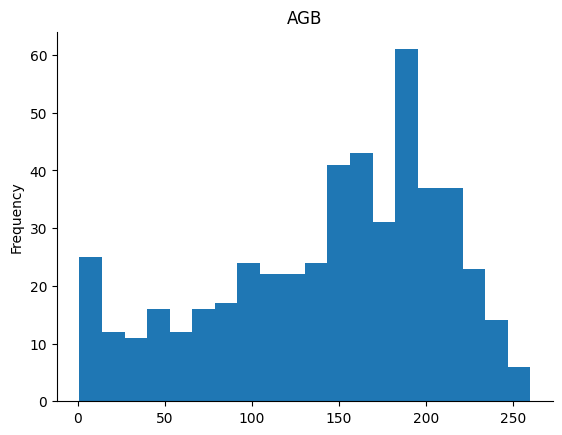

In [ ]:
from matplotlib import pyplot as plt
df_ndvi['AGB'].plot(kind='hist', bins=20, title='AGB')
plt.gca().spines[['top', 'right',]].set_visible(False)

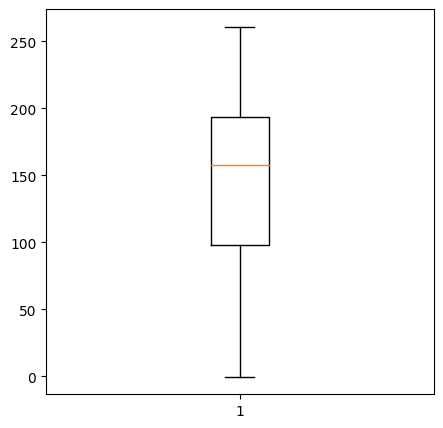

In [ ]:
# Criando o dataset
data = np.random.normal(df_ndvi['AGB'])
##Definindo o tamanho da figura
fig = plt.figure(figsize =(5, 5))
# Plotando os Resultados
plt.boxplot(data)
# Apresentando os resultados
plt.show()

## Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-2A.

Sentinel-2 é uma missão de imageamento multiespectral de alta resolução e ampla cobertura, que apoia estudos de monitoramento terrestre do programa Copernicus. As imagens multiespectrais para este estudo serão obtidas através da coleção Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-2A (ESA, 2023a).


As imagens contém 13 bandas multiespectrais com resolução espaciais variadas, cobrindo diferentes regiões do espectro eletromagnético. Dessas bandas, as que compõem a luz visível (azul = ‘B2’, verde= ‘B3’; vermelho = ‘B4’) e o infravermelho-próximo (NIR = ‘B4’) possuem 10 m de resolução espacial; Red-Edge (B5; B6; B7; B8A) e o infravermelho de ondas curtas (SWIR1 = ‘B11’; SWIR 2 = ‘B12’) possuem 20 m; enquantos as bandas ‘B1’, ‘B9’ e ‘QA60’ possuem 60 metros (ESA, 2023a).


In [ ]:
# Mascara de nuvens para a banda pixel_qa SR Sentinel 2
def maskS2clouds(image):
  qa = image.select('QA60')
  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11
  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
  #Return the masked and scaled data, without the QA bands.
  return image.updateMask(mask).divide(10000)\
      .select("B.*")\
      .copyProperties(image, image.propertyNames())\
      .set('data', image.date().format('YYYY-MM-dd'))\
      .set({'millis': image.date().millis()})\
      .set({'ID': image.get('system:index')})

In [ ]:
def calculate_indices(image):
    # Selecionar as bandas necessárias
    blue = image.select('B2')  # Banda Azul
    green = image.select('B3')  # Banda Verde
    red = image.select('B4')  # Banda Vermelha
    nir = image.select('B8')  # Banda NIR (Infravermelho Próximo)
    swir1 = image.select('B11')  # Banda SWIR1 (Infravermelho de Onda Curta 1)
    swir2 = image.select('B12')  # Banda SWIR2 (Infravermelho de Onda Curta 2)

    # Calculando os índices
    evi = image.expression(
        '2.5 * (NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1)', {
            'NIR': nir,
            'RED': red,
            'BLUE': blue
        }).rename('EVI')

    nbr = image.normalizedDifference(['B8', 'B12']).rename('NBR')
    ndmi = image.normalizedDifference(['B8', 'B11']).rename('NDMI')
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    mndwi = image.normalizedDifference(['B3', 'B11']).rename('MNDWI')
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

    return image.addBands([evi,nbr, ndmi,ndwi,mndwi,ndvi])

In [ ]:
##Agora vamos obter um ee.Image de um ee.ImageCollection
Sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR')\
         .filterBounds(ee.Geometry.Point([-52.34007901938789,-25.901559629835102]))\
         .filterDate('2020-01-01', '2020-12-31')\
         .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',5))\
         .map(maskS2clouds)\
         .select(['B.*'])\
         .map(calculate_indices)\


print('Nº total de imagens :', Sentinel2.size().getInfo())

Nº total de imagens : 28


In [ ]:
##Listar as imagens ID e datas
ID_date_list = Sentinel2.reduceColumns(ee.Reducer.toList(2), ['system:id','data']).values().get(0)
ID_date_list.getInfo()

[['COPERNICUS/S2_SR/20200118T133219_20200118T133218_T22JCS', '2020-01-18'],
 ['COPERNICUS/S2_SR/20200222T133221_20200222T133219_T22JCS', '2020-02-22'],
 ['COPERNICUS/S2_SR/20200227T133219_20200227T133221_T22JCS', '2020-02-27'],
 ['COPERNICUS/S2_SR/20200303T133221_20200303T133220_T22JCS', '2020-03-03'],
 ['COPERNICUS/S2_SR/20200308T133219_20200308T133222_T22JCS', '2020-03-08'],
 ['COPERNICUS/S2_SR/20200313T133221_20200313T133220_T22JCS', '2020-03-13'],
 ['COPERNICUS/S2_SR/20200323T133221_20200323T133221_T22JCS', '2020-03-23'],
 ['COPERNICUS/S2_SR/20200412T133221_20200412T133223_T22JCS', '2020-04-12'],
 ['COPERNICUS/S2_SR/20200422T133231_20200422T133226_T22JCS', '2020-04-22'],
 ['COPERNICUS/S2_SR/20200422T133231_20200422T133935_T22JCS', '2020-04-22'],
 ['COPERNICUS/S2_SR/20200427T133219_20200427T133219_T22JCS', '2020-04-27'],
 ['COPERNICUS/S2_SR/20200502T133231_20200502T133228_T22JCS', '2020-05-02'],
 ['COPERNICUS/S2_SR/20200507T133219_20200507T133222_T22JCS', '2020-05-07'],
 ['COPERNICU

In [ ]:
# Nome das bandas disponíveis para nossa análise
Sentinel2.first().bandNames().getInfo()

['B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B9',
 'B11',
 'B12',
 'EVI',
 'NBR',
 'NDMI',
 'NDWI',
 'MNDWI',
 'NDVI']

In [ ]:
geometry = ee.Geometry.Polygon(
        [[[-52.4459524870798, -25.697343358672263],
          [-52.4459524870798, -26.029755652737688],
          [-52.1328421355173, -26.029755652737688],
          [-52.1328421355173, -25.697343358672263]]]);

In [ ]:
# Reduzindo a coleção pela mediana
imageS2 = Sentinel2.median()
rgb_vis = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

Map.addLayer(imageS2,rgb_vis,'Sentinel 2')
Map

Map(bottom=75596.0, center=[-25.045448803258, -47.91963326342274], controls=(WidgetControl(options=['position'…

In [ ]:
#exportar image
task = ee.batch.Export.image.toDrive(
    image=imageS2.toFloat(),
    description='Sentinel_2_features',
    folder='TCC_MBA',
    maxPixels= 1e13,
    region=geometry,
    scale=10,
    crs='EPSG:4326'
)
task.start()

In [ ]:
task.status()

{'state': 'RUNNING',
 'description': 'Sentinel_2_features',
 'priority': 100,
 'creation_timestamp_ms': 1718676721462,
 'update_timestamp_ms': 1718676848368,
 'start_timestamp_ms': 1718676726346,
 'task_type': 'EXPORT_IMAGE',
 'attempt': 1,
 'id': 'GE2IT2UOH4DZ7TZ44DXI327B',
 'name': 'projects/ee-sandrosenamachado/operations/GE2IT2UOH4DZ7TZ44DXI327B'}

In [ ]:
# # Check data ID, date and cloud percentage
# s2properties = Sentinel2.first()
# s2properties = Sentinel2.set({'ID': Sentinel2.get('system:id')})\
#                    .set({'millis': Sentinel2.date().millis()})\
#                    .set('date', Sentinel2.date().format())

# print('ID:', s2properties.get('ID').getInfo())
# print('date:', s2properties.get('date').getInfo())
# print('Percentual de Nuvens:', s2properties.get('CLOUDY_PIXEL_PERCENTAGE').getInfo())

In [ ]:
# A função clamp(-1, 1) está sendo usada para limitar os valores de image dentro do intervalo de -1 a 1.
# Isso significa que todos os valores na image que são menores que -1 serão
# ajustados para -1, e todos os valores que são maiores que 1 serão ajustados
# para 1. Valores entre -1 e 1 permanecerão inalterados. Esta operação é
# comum para garantir que os dados estejam dentro de um intervalo específico, o
# que pode ser útil para várias aplicações, como processamento de imagens ou
# alimentação de dados em modelos de aprendizado de máquina.

##Padronizando os dados entre -1 e 1
indexImage = imageS2.clamp(-1, 1).unitScale(-1, 1) ##Após o clamping, a função unitScale(-1, 1) é aplicada. Essa função normaliza os valores da imagem para que eles estejam em uma escala unitária entre -1 e 1.
indexImage

## NASA SRTM Digital Elevation 30m (Shuttle Radar Topography Mission)

O Modelo Digital de Elevação (MDE) do SRTM (Shuttle Radar Topography Mission) é um projeto conjunto da NASA e da Agência Espacial Nacional da Alemanha (DLR) que mapeou a elevação terrestre para o ano de 2000. A topografia influencia a estrutura da vegetação e a biomassa, por isso é importante considerá-la no mapeamento. O MDE está disponível como uma imagem única global de resolução espacial de 30 m (Farr et al. 2007).

In [ ]:
# .log(): Esta função aplica uma transformação logarítmica aos valores de elevação da imagem.
# Essa transformação é frequentemente usada para reduzir a variação nos dados de elevação,
# tornando os padrões mais fáceis de identificar, especialmente quando há grandes diferenças nos valores de elevação.

# .divide(10): A imagem resultante da transformação logarítmica é então dividida por 10.
# Esta é uma forma de normalização e pode ser específica para o contexto ou objetivo da análise.

# Adicionando dados de Elevação
srtm = ee.Image("USGS/SRTMGL1_003")
srtm = srtm.clip(region).log().divide(10).clamp(0, 1).toFloat()##Scaled it to 0 - 1

In [ ]:
# ADICIONAR SLOPE (DECLIVIDADE)
# Calculando a declividade. Units are degrees, range is [0,90).
slope = ee.Terrain.slope(srtm)
slope = slope.rename('slope')

In [ ]:
# Complete image com indices and DEM...
image = indexImage.sqrt().addBands([srtm,slope])\
                    .reproject('EPSG:4326', None, 100)

image.bandNames().getInfo()

['B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B9',
 'B11',
 'B12',
 'EVI',
 'NBR',
 'NDMI',
 'NDWI',
 'MNDWI',
 'NDVI',
 'elevation',
 'slope']

In [ ]:
extract_bands = imageS2.reduceRegions(
                collection= extract,
                reducer=ee.Reducer.median(),
                scale=10
                )


# ##extrair valores para as bandas e amostras
# extract_bands = image.sampleRegions(
#   collection= randomPoints,
#   scale= 100,
#   geometries=True
#   #'properties': ['AGB']
# );

extract_bands

## Sentinel-1 SAR GRD: C-band Synthetic Aperture Radar Ground Range Detected, log scaling

O Sentinel-1 é um radar de abertura sintética (SAR) que fornece dados sobre a estrutura da superfície da terra, e sofre menos interferência das condições climáticas ou da presença de luz solar, em comparação com sensores ópticos como o Sentinel-2. Ao contrário do Sentinel-2 que captura radiação solar refletida pela superfície, o Sentinel-1 emite pulsos de radar e registra a energia refletida pelos objetos na Terra, também chamada de retroespalhamento (backscattering) (ESA, 2023b).

As imagens de radar serão obtidas através da coleção Sentinel-1 SAR GRD: C-band Synthetic Aperture Radar Ground Range Detected, log scaling que oferece quatro bandas com diferentes polarizações (VV, HH, VH e HV), com resolução espacial de 10 m e unidade de medida em escala logarítmica (dB), permitindo a detecção de mudanças sutis na biomassa. Esse produto foi pré-processado através de calibração radiométrica, remoção de ruído termal, correção do terreno com SRTM 30 (Shuttle Radar Topography Mission) e ASTER DEM e ortorretificação. Contudo, este produto ainda precisa de pré-processamento adicional como filtro de ruído Speckle (ESA, 2023b).

In [ ]:
# /** SENTINEL-1 DATA PROCESSING: */
# // The goal of this algorithm is process SAR images from Sentinel-1. The code does:

# // 1) Creates a function to apply an speckle filter: in this case by Focal Median method;

# // 2) Creates a function that will, based on band histogram (from VV and VH FLOAT bands),
# // remove an "heavy-tail" from their histograms: this part of distribution that is understood as
# // outliers;

# // 3) Applying all functions above, the code creates a variable containing a image
# // collection for each band. The result are the bands Sigma0_VV and Sigma0_VH;

# // 5) Creates and apply functions to compute all the SAR vegetation indices of interest:
# // DPSVI original (Periasamy, 2018) and DPSVI modified;

# // 6) Finally, the code create mosaics for the area, combining images from the data period
# // selectioned;

#   /** Function to apply speckle noise removal filter by Focal Median: */
#   // The window (the kernel) used to apply the filter is in pixel number, that is odd number
#   function MedianVV(image){
#     return image.addBands(image.focal_median({radius: 5,
#                                               kernelType: 'square',
#                                               units: 'pixels'})
#                                .rename(['Sigma0_VV']));
#   }
#   function MedianVH(image){
#     return image.addBands(image.focal_median({radius: 5,
#                                               kernelType: 'square',
#                                               units: 'pixels'})
#                                .rename(['Sigma0_VH']));
#   }

#   /** Function to mask outliers in VV band based on histogram analysis */
#   function maskVV(image){
#     var quantil90 = image.reduceRegion({reducer:
#                             ee.Reducer.percentile({percentiles: ee.List([95]),
#                                                    outputNames: ee.List(['p95'])}),
#                                         scale: 10,
#                                         bestEffort: true});
#     var Outliers = image.select('VV').lte(ee.Number(quantil90.get('VV')));
#     return image.updateMask(Outliers);}
#   function maskVH(image){
#     var quantil90 = image.reduceRegion({reducer:
#                             ee.Reducer.percentile({percentiles: ee.List([95]),
#                                                    outputNames: ee.List(['p95'])}),
#                                         scale: 10,
#                                         bestEffort: true});
#     var Outliers = image.select('VH').lte(ee.Number(quantil90.get('VH')));
#     return image.updateMask(Outliers);}

#   /** Vars that will receive and pre-process the Sentinel-1 SAR choiced images: */
#   var sentinel1VV = ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
#                       .filter(ee.Filter.eq('instrumentMode', 'IW'))
#                       .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
#                       //.filter(ee.Filter.eq('relativeOrbitNumber_start', 82)) //Filter necessary to basin 779926
#                       .filter(ee.Filter.eq('resolution_meters', 10))
#                       .filterBounds(aoi) //roi: Necessary to Doce River Basin, to avoid select excess images
#                       .filterDate(start, finish)
#                       .select('VV')
#                       .map(maskVV)
#                       .map(MedianVV)
#                       .select('Sigma0_VV');

#   // VH band
#   var sentinel1VH = ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
#                       .filter(ee.Filter.eq('instrumentMode', 'IW'))
#                       .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
#                       //.filter(ee.Filter.eq('relativeOrbitNumber_start', 82)) //Filter necessary to basin 779926
#                       .filter(ee.Filter.eq('resolution_meters', 10))
#                       .filterBounds(aoi) //roi: Necessary to Doce River Basin, to avoid select excess images
#                       .filterDate(start, finish)
#                       .select('VH')
#                       .map(maskVH)
#                       .map(MedianVH)
#                       .select('Sigma0_VH');

#   /** Combining both image collections (Sigma0_VV and Sigma0_VH): */
#   var sentinel1 = sentinel1VV.combine(sentinel1VH);
#   //print(sentinel1, "Sentinel-1 filtered images");

#   /** Computing vegetation index over each image in collection: */
#   // The outputs of this function are:
#       // The original Dual Polarization SAR Vegetation Index (DPSVI; Perisamy, 2018);
#       // and the modified DPSVI (proposed here):
#   function indices(image){
#     var max = image.reduceRegion({reducer: ee.Reducer.max(), scale: 10,
#                                   geometry: aoi, bestEffort: true});
#     var DPSVIoriginal = image.expression(
#       '(((VVmax - VV)+VH)/1.414213562) * ((VV+VH)/VV) * VH', {
#         'VH': image.select('Sigma0_VH'),
#         'VV': image.select('Sigma0_VV'),
#         'VVmax': ee.Number(max.get('Sigma0_VV'))
#       });
#     var DPSVIm = image.expression(
#       '(VV*VV+VV*VH)/1.414213562',{
#         'VH': image.select('Sigma0_VH'),
#         'VV': image.select('Sigma0_VV')
#       });

#     return image.addBands([DPSVIm.rename("DPSVIm"),
#                            DPSVIoriginal.rename("DPSVIo")]);}

#   // The follow function apply the DPSVI normalization procedure:
#   function DPSVInorm(image){
#     var max = image.reduceRegion({reducer: ee.Reducer.max(),
#                                   scale: 10,
#                                   geometry: aoi,
#                                   bestEffort: true});
#     var min = image.reduceRegion({reducer: ee.Reducer.min(),
#                                   scale: 10,
#                                   geometry: aoi,
#                                   bestEffort: true});
#     var DPSVI = image.expression(
#       '(DPSVI - DPSVImin) /(DPSVImax - DPSVImin)',{
#         'DPSVI': image.select('DPSVIm'),
#         'DPSVImax': ee.Number(max.get('DPSVIm')),
#         'DPSVImin': ee.Number(min.get('DPSVIm'))
#       });
#     return image.addBands(DPSVI.rename('DPSVI'));
#   }

#   // Now the functions of this section are applied over Image Collection:
#   var S1 = sentinel1.map(indices);
#   var S1new = S1.map(DPSVInorm)
#                 .select(['Sigma0_VV', 'Sigma0_VH', 'DPSVIo', 'DPSVI'])
#                 .map(subset);
#   //print(S1new, "Pos processing images S1");

#   /** Mosaicking Sentinel-1 scenes by date */
#   // Difference in days between start and finish
#   var diff = finish.difference(start, 'month');
#   //print(diff, "Difference of months");

#   // Make a list of all dates
#   var range = ee.List.sequence(0, diff.subtract(1)).map(function(day){return start.advance(day,'month')});
#   print(range, "List of all months");

#   // Funtion for iteraton over the range of dates
#   var day_mosaics = function(date, newlist) {
#     // Cast
#     date = ee.Date(date);
#     newlist = ee.List(newlist);

#   // Filter collection between date and the next day
#   var filtered = S1new.filterDate(date, date.advance(1,'month'));

#   // get date as YEARMONTHDAY. For example, for January 8th 2010
#   // would be: 20100108
#   var date_formatted = ee.Number.parse(date.format('YYYYMMdd'));

#   // Make the mosaic
#   var image = ee.Image(filtered.mosaic()).set('Mosaic', date_formatted);

#   // Add the mosaic to a list only if the collection has images
#   return ee.List(ee.Algorithms.If(filtered.size(), newlist.add(image), newlist));
# };

#   // Iterate over the range to make a new list, and then cast the list to an imagecollection
#   var newcols1 = ee.ImageCollection(ee.List(range.iterate(day_mosaics, ee.List([]))));
#   //print(newcols1, "Collection with Sentinel-1 mosaic images");

# /** COMBINING LANDSAT 8 AND SENTINEL-1 MOSAICS IN ONE IMAGE COLLECTION: */
# var images = newcoll8.select(['NDVI','EVI','slope'])
#                      .combine(newcols1);
# //print(images, "Image collection containing L8 and S1 data");

# /** VISUALIZING ON THE MAP THE AOI AND SCENES PROCESSED: */
# Map.centerObject(aoi);
# //Map.addLayer(aoi);
# //var NDVIvisParams = {min: 1, max: 33};
# //Map.addLayer(images.first(), {bands: ['EVI'], visParams: NDVIvisParams}, "EVI");
# //Map.addLayer(images.first(), {bands: ['DPSVI'], visParams: NDVIvisParams}, "DPSVI");

# /** GETTING RANDOMLY SAMPLES: */
# // Sample mosaic images
# //var listOfImages = images.toList(images.size());
# //print(listOfImages, "Lista de imagens selecionadas e processadas.");

# //var image = ee.Image(listOfImages.get(0));
# var image = images.first();
# //print(image, "Product in analysis");

# var sample = image.sample({region: aoi,
#                            scale: 30,
#                            tileScale: 16,
#                            numPixels: 3000 //Note that numPixels is the approximated number of samples to collect
# });
# //print(sample, "Amostras coletadas");

# // Export sample tables obtained from Sentinel-1 and Landsat-8 mosaics at same position:
# Export.table.toDrive({collection: sample,
#                       folder: 'Chapter1_Indices_baciaDoce',
#                       description: 'DPSVI-NDVI-EVI_2015-10'});

# // Visualize the behavior of spectral and microwave indices:
# var chart = ui.Chart.feature.byFeature(sample, 'NDVI', ['DPSVI'])
#               .setChartType('ScatterChart')
#               .setOptions({pointSize: 2,
#                            pointColor: 'red',
#                            title: "Bacia Doce",
#                            titleY: 'DPSVI (dl)',
#                            titleX: 'NDVI (dl)',
#                            trendlines:{0: {
#                                           type: 'linear',
#                                           color: 'green',
#                                           showR2: true,
#                                           visibleInLegend: true}}});
# print(chart);
# var chart1 = ui.Chart.feature.byFeature(sample, 'NDVI', ['DPSVIo'])
#               .setChartType('ScatterChart')
#               .setOptions({pointSize: 2,
#                            pointColor: 'red',
#                            title: "Bacia Doce",
#                            titleY: 'DPSVI',
#                            titleX: 'NDVI (dl)',
#                            trendlines:{0: {
#                                           type: 'linear',
#                                           color: 'green',
#                                           showR2: true,
#                                           visibleInLegend: true}}});
# //print(chart1);

# /** ANALYSING THE IMAGE USING A BAND SCATTERPLOT */
# //var result = image.reduceRegion({reducer: ee.Reducer.toList(),
# //                                 geometry: aoi,
# //                                 bestEffort: true,
# //                                 scale: 1000});
# // Convert the band data to plot on the y-axis to arrays.
# //var yValues = ee.Array(result.get('DPSVI'));
# // The band data to plot on the x-axis is a List.
# //var xValues = result.get('EVI');
# // Make a band correlation chart.
# //var chart2 = ui.Chart.array.values(yValues, 0, xValues)
# //               .setOptions({title: '2015-10-01',
# //                            hAxis: {'title': 'EVI (dl)'},
# //                            vAxis: {'title': 'DPSVI (dl)'},
# //                            pointSize: 3});
# //Print the chart.
# //print(chart2, "Band scatter plot");

# Cross-validation and normalization
7-folds cross validation and normalization with RobustScaler


In [ ]:
def cross_val(X,y,folds=7,random_state=42):

    '''
    cross_val function sets 2 contraints:
    - points belonging to the same plot (plot_df) end up in either the training or the validation set;
    - only the training set fits the scaler.
    it outputs training and validation set

               REQUIRES
               plot_df!

    plot_df: forestry plot unique identifier
    X: independent variables (Vegetation Indices, texture measures, etc.)
    y: target variable (AGB)

    '''

    kf = KFold(n_splits=folds)

    # interates over number of train_plots and val_plots for each fold
    for train_plots, val_plots in kf.split(np.unique(plot_df['plot_number'].unique())):

        # goes to X, checks which entries have plot number in the train_plots and stacks the entries
        X_train =np.vstack([X[plot_df['plot_number']==plot].values for plot in train_plots])
        # goes to X, checks which entries have plot number in the train_plots and stacks the entries
        X_val =np.vstack([X[plot_df['plot_number']==plot].values for plot in val_plots])

        # goes to y, checks which entries have plot number in the train_plots and stacks the entries
        y_train =pd.DataFrame(np.vstack([y[plot_df['plot_number']==plot].values for plot in train_plots]))
        y_train.columns=y.columns
        # goes to y, checks which entries have plot number in the train_plots and stacks the entries
        y_val =pd.DataFrame(np.vstack([y[plot_df['plot_number']==plot].values for plot in val_plots]))
        y_train.columns=y.columns

        # scale with RobustScaler
        scaler = preprocessing.RobustScaler().fit(X_train)
        X_train = pd.DataFrame(scaler.transform(X_train))
        X_train.columns=X.columns
        X_val = pd.DataFrame(scaler.transform(X_val))
        X_val.columns=X.columns
        yield (X_train,y_train),(X_val,y_val)

# Model Fitting

In [ ]:
# ##Labels das bandas utilizadas
# labels =['AGB', 'EVI', 'MNDWI', 'NBR', 'NDMI', 'NDVI', 'NDWI', 'B1',
# 'B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'elevation']
# ##Crie uma lista com os dados da malha amostra que você criou
# Lista_df = extract_bands.reduceColumns(ee.Reducer.toList(15), labels).values().get(0)
# ##Visualize seu dataframe no utilizando os pandas
# df = pd.DataFrame(Lista_df, columns=labels)
# df

In [ ]:
df = geemap.ee_to_df(extract_bands)
df.head()

,AGB,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,EVI,MNDWI,NBR,NDMI,NDVI,NDWI
0,61,0.01485,0.13230,0.06150,0.02175,0.03760,0.02600,0.05535,0.19370,0.25695,0.28480,0.28750,0.30485,0.504950,-0.563375,0.647836,0.368520,0.831413,-0.764935
1,245,0.01435,0.13325,0.05805,0.02255,0.03950,0.02425,0.06075,0.17710,0.22015,0.24665,0.24425,0.24625,0.455135,-0.540670,0.624432,0.313862,0.835650,-0.732044
2,157,0.01350,0.15280,0.06060,0.01690,0.03710,0.01930,0.06820,0.24720,0.32730,0.34270,0.35490,0.31850,0.609982,-0.606127,0.691228,0.379568,0.883945,-0.792239
3,158,0.01270,0.14620,0.06585,0.02045,0.03735,0.02115,0.06920,0.22260,0.27885,0.28800,0.30050,0.28395,0.526469,-0.591184,0.650644,0.337908,0.867215,-0.762507
4,74,0.01465,0.15625,0.07005,0.01985,0.03530,0.02375,0.05750,0.21355,0.28745,0.30255,0.32295,0.30800,0.537927,-0.637833,0.614296,0.311764,0.859071,-0.793679


In [ ]:
##Exportar dados csv das amostras

# Substituir caminho
df.to_csv('/content/drive/MyDrive/TCC_MBA/SampleAGB.csv')

## Random Forest Regression


In [ ]:
## Fatiar as amostras
# // Split train and test
extract_bands = extract_bands.randomColumn(seed=42);  # Adiciona uma coluna aleatória para ajudar na divisão dos dados em conjuntos de treino e teste.

train = extract_bands.filter(ee.Filter.lte('random', 0.7));  # Cria o conjunto de treino selecionando 80% dos dados (valores onde a coluna aleatória é menor ou igual a 0.8).
test = extract_bands.filter(ee.Filter.gt('random', 0.7));  # Cria o conjunto de teste com os 20% restantes dos dados (valores onde a coluna aleatória é maior que 0.8).

# Definição das variáveis (bandas e elevação) a serem utilizadas na análise.
variables = ['EVI', 'MNDWI', 'NBR', 'NDMI', 'NDVI', 'NDWI', 'SR_B1',
             'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'elevation']

## Criando modelo para análise
model = ee.Classifier.smileRandomForest(100).train(train, 'AGB', variables).setOutputMode('REGRESSION');  # Cria e treina um modelo de floresta aleatória com 100 árvores, usando as variáveis definidas e configurando o modo de saída para regressão.

print(model.explain().getInfo());  # Imprime informações sobre o modelo treinado para análise e compreensão.

In [ ]:
##Verificando a importância de cada banda
variable_importance = ee.Feature(None, ee.Dictionary(model.explain().getInfo()).get('importance'));
variable_importance.getInfo()

In [ ]:
##Convertendo dados para uma lista
lista_variable_importance = ee.List(variable_importance).getInfo()
##Criando dataframe da importância das variáveis
variable_importance_df = pd.DataFrame(lista_variable_importance, columns=['properties',])
variable_importance_df =variable_importance_df.sort_values(by='properties', ascending=False)
variable_importance_df.round(2).reset_index()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurando o tamanho do gráfico
plt.figure(figsize=(12, 6))

# Criação do gráfico de barras
ax1 = sns.barplot(x='index', y="properties", data=variable_importance_df.reset_index(), palette='RdYlGn')

# Ajuste dos rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos e alinha-os à direita para melhor visualização

# Definição dos rótulos e título com fontes maiores para melhor legibilidade
plt.xlabel("Bandas", fontsize=14)
plt.ylabel("Importância", fontsize=14)
plt.title("Importâncias das variáveis", fontsize=16)

# Exibindo o gráfico
plt.tight_layout()  # Ajusta o layout para evitar sobreposição de elementos
plt.show()

In [ ]:
# Classificar os dados de teste
sample_test = test.classify(model, 'prediction').map(lambda feat:
    feat.set('residual', ee.Number(feat.get('AGB')).subtract(ee.Number(feat.get('prediction'))).abs())) #Esta parte do código utiliza a função map para iterar sobre cada amostra (feat) no conjunto de dados de teste.
                                                                                                        #Para cada amostra, ele pega o valor real ('AGB', que pode ser, por exemplo,a biomassa acima do solo ou outro valor de interesse) e subtrai dele o valor previsto ('prediction').

# O resultado final sample_test é um conjunto de dados de teste com duas
# novas colunas adicionadas: 'prediction',que contém os valores previstos pelo modelo, e 'residual',
# que contém os resíduos (diferença absoluta) entre os valores observados e previstos.
sample_test  # Objeto contendo os dados de teste classificados e os resíduos calculados.

# Obter a média dos valores reais de AGB
meanAGB = sample_test.aggregate_mean('AGB')

# Usar map para calcular a diferença ao quadrado de cada valor de AGB em relação à média
SST_calculation = sample_test.map(lambda feat: ee.Feature(None, {'sst': ee.Number(feat.get('AGB')).subtract(meanAGB).pow(2)}))

# Calcular a SST somando todos os valores de sst
SST = SST_calculation.aggregate_sum('sst')

# Calcular a SSR (soma dos quadrados dos resíduos)
SSR = sample_test.aggregate_sum('residual')

# Calcular o R^2
R2 = ee.Number(1).subtract(SSR.divide(SST))

# Imprimir o R^2 (pode precisar ser convertido para um valor numérico no cliente, dependendo do seu ambiente)
print('R^2:', R2.getInfo())

In [ ]:
##Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

##nome das bandas
labels = ['AGB', 'EVI', 'MNDWI',
 'NDMI','NDVI', 'NDWI', 'SR_B1', 'SR_B2',
 'SR_B3', 'SR_B4',  'SR_B5', 'SR_B6',
 'SR_B7', 'elevation', 'prediction', 'random',
 'residual']

##Crie uma lista com os dados da malha amostra que você criou
Lista_df = sample_test.reduceColumns(ee.Reducer.toList(17), labels).values().get(0)
##Visualize seu dataframe no utilizando os pandas
df_ = pd.DataFrame(Lista_df.getInfo(), columns=labels)
df_

In [ ]:
# // Show the AGB prediction
agbPrediction = image.classify(model, 'AGB');
Map=geemap.Map()
Map.add_basemap('HYBRID')
Map.addLayer(agbPrediction, {'min': 0, 'max': 200, 'palette': ['lightyellow', 'green'] }, 'AGB Prediction')
Map.centerObject(region,10)
Map

In [ ]:
# Modelo de regressão linear
X = df_[['AGB']]
y = df_['prediction']
modelo = LinearRegression().fit(X, y)

# Calculando a equação e R^2
slope = modelo.coef_[0]
intercept = modelo.intercept_
r_squared = r2_score(y, modelo.predict(X))
equation = f"y = {slope:.2f}x + {intercept:.2f}"
r2_text = f"R^2 = {r_squared:.2f}"

# Configurando o tamanho do gráfico
plt.figure(figsize=(10, 8))

# Gerando o gráfico de dispersão
plt.scatter(df_['AGB'], df_['prediction'], color='blue', label='Dados observados (azul)')
plt.plot(df_['AGB'], modelo.predict(X), color='red', label='Linha de regressão (vermelho)')

# Adicionando título e rótulos
plt.title('Scatter Plot of AGB vs Prediction')
plt.xlabel('AGB')
plt.ylabel('Prediction')

# Adicionando a legenda
plt.legend()

# Posicionamento do texto da equação e R^2 na parte inferior do gráfico
plt.text(0.75, 0.05, equation, transform=plt.gca().transAxes, fontsize=12)
plt.text(0.75, 0.02, r2_text, transform=plt.gca().transAxes, fontsize=12)

# Mostrando o gráfico
plt.show()

In [ ]:
##Exportar o melhor modelo (gerado aleatóriamente)
df_.to_csv('/content/drive/MyDrive/Workshop/Bases/pred_rf.csv')

In [ ]:
##Estatística Com DF já definido
df_ = pd.read_csv('/content/drive/MyDrive/Workshop/Bases/pred_rf.csv')
# Modelo de regressão linear
X = df_[['AGB']]
y = df_['prediction']
modelo = LinearRegression().fit(X, y)

# Calculando a equação e R^2
slope = modelo.coef_[0]
intercept = modelo.intercept_
r_squared = r2_score(y, modelo.predict(X))
equation = f"y = {slope:.2f}x + {intercept:.2f}"
r2_text = f"R^2 = {r_squared:.2f}"

# Gerando o gráfico de dispersão
plt.scatter(df_['AGB'], df_['prediction'], color='blue')
plt.plot(df_['AGB'], modelo.predict(X), color='red')
plt.title('Scatter Plot of AGB vs Prediction')
plt.xlabel('AGB')
plt.ylabel('Prediction')
plt.text(np.max(df_['AGB'])/2, np.max(df_['prediction']), equation, fontsize=12)
plt.text(np.max(df_['AGB'])/2, np.max(df_['prediction']) - 10, r2_text, fontsize=12)
plt.show()

## Shallow Neural Networks

In [ ]:
# Parameter
FEATURES = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'EVI','NDVI','NBR', 'NDMI', 'NDWI', 'elevation']
LABEL = ['AGB']
SAMPLE_PATH = '/content/drive/MyDrive/Workshop/Bases/SampleAGB.csv'
IMAGE_PATH = '/content/drive/MyDrive/Workshop/Landsat_100m.tif'

In [ ]:
# Load image
image = rasterio.open(IMAGE_PATH)  # Abre a imagem localizada no caminho especificado por IMAGE_PATH usando a biblioteca rasterio.

bandNum = image.count  # Obtém o número de bandas da imagem.
height = image.height  # Obtém a altura da imagem em pixels.
width = image.width  # Obtém a largura da imagem em pixels.
crs = image.crs  # Obtém o sistema de referência de coordenadas da imagem.
transform = image.transform  # Obtém a transformação afim da imagem, que relaciona coordenadas de pixel com coordenadas do mundo real.
shape = (height, width)  # Cria uma tupla com a altura e largura da imagem.

# Definindo o tamanho da figura para a visualização usando matplotlib
fig, ax = plt.subplots(figsize=(15, 12))  # Você pode ajustar o tamanho conforme necessário

##Transformando a imagem RGB
src_rgb = image.read([5,4,3])
##Visualizando imagem
show(src_rgb**5,transform=image.transform,title='Image-bands 4,3,2')


In [ ]:
# Ler as amostras
samples = pd.read_csv(SAMPLE_PATH)[FEATURES + LABEL]
samples

In [ ]:
# Split into train and test
train, test = train_test_split(samples, test_size=0.2, shuffle=True, random_state=42)
# Esta linha divide o DataFrame 'samples' em dois subconjuntos: 'train' e 'test'.
# 'test_size=0.2' indica que 20% dos dados devem ser reservados para o conjunto de teste.
# 'shuffle=True' embaralha os dados antes da divisão para garantir a aleatoriedade.

# Get variables input and output
train_input = train[FEATURES].to_numpy()
test_input = test[FEATURES].to_numpy()
# 'FEATURES' é uma lista de nomes de colunas que são usadas como variáveis de entrada para o modelo.
# 'to_numpy()' converte as colunas especificadas em arrays do NumPy para o treinamento do modelo.

train_output = train[LABEL].to_numpy().astype(float) / 450
test_output = test[LABEL].to_numpy().astype(float) / 450
# 'LABEL' é o nome da coluna que contém a variável de saída ou rótulo para o modelo.
# 'astype(float)' converte os valores para o tipo float para cálculos numéricos.
# A divisão por 450 pode ser uma forma de normalização para escalar os valores dos rótulos.

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')
# Esta parte imprime a forma dos dados de entrada e saída para os conjuntos de treino e teste.
# 'shape' é uma propriedade de arrays NumPy que retorna as dimensões do array.

In [ ]:
# Faça um modelo para nossos dados
# Forma de entrada
train_shape = train_input.shape
input_shape = (train_shape[1])
# Aqui, estamos definindo a forma da entrada (input_shape) do modelo.
# Isso é feito obtendo o número de features (train_shape[1], que representa o número de colunas)
# do array train_input que contém os dados de treinamento.

# Parâmetros do modelo
neuron = 32
drop = 0.2
# 'neuron' define o número de neurônios nas camadas ocultas.
# 'drop' define a taxa de dropout, que é uma técnica de regularização
# usada para prevenir o overfitting. Dropout 'desliga' aleatoriamente
# uma fração dos neurônios durante o treinamento.

# Modelo sequencial
# A função de ativação ReLU (Rectified Linear Unit) é uma função amplamente usada em redes neurais profundas.

model = Sequential([
  Input(input_shape),
  # A camada de entrada do modelo é definida com a forma da entrada (input_shape).
  Dense(neuron * 4, activation='relu'),
  # Uma camada densa com 'neuron * 4' (ou seja, 128) neurônios e a função de ativação ReLU.
  Dropout(drop),
  # Uma camada de Dropout aplicada após a primeira camada densa.
  Dense(neuron * 2, activation='relu'),
  # Segunda camada densa com 'neuron * 2' (ou seja, 64) neurônios e ativação ReLU.
  Dropout(drop),
  # Outra camada de Dropout após a segunda camada densa.
  Dense(neuron * 1, activation='relu'),
  # Terceira camada densa com 'neuron * 1' (ou seja, 32) neurônios e ativação ReLU.
  Dropout(drop),
  # Mais uma camada de Dropout após a terceira camada densa.
  Dense(1, activation='relu')
  # A camada de saída do modelo com um único neurônio e ativação ReLU.
  # O uso de ReLU na saída é incomum para problemas de regressão (se este for o caso),
  # normalmente se usaria uma função linear (sem ativação) ou sigmoidal para problemas de classificação binária.
])

model.summary()
# Este comando imprime um resumo do modelo, mostrando todas as camadas,
# a forma da saída de cada camada e o número total de parâmetros.

In [ ]:
# Train the model

# Compline the model
model.compile(
    optimizer='Adam',  #O otimizador escolhido é o Adam, que é um algoritmo popular de otimização estocástica usado para ajustar os pesos da rede neural durante o treinamento.
    loss='mse',#A função de perda é definida como 'mse', que significa "Erro Quadrático Médio" (Mean Squared Error).
    metrics=['MeanSquaredError'] # métrica a ser avaliada durante o treinamento é o Erro Quadrático Médio.
)

# Crie um retorno de chamada para interromper o treinamento se a perda não diminuir
#  Esse callback monitora a perda ('loss') durante o treinamento e interrompe o treinamento se a perda não diminuir por um número específico de épocas.
#  Neste caso, a paciência é definida como 5, o que significa que o
#  treinamento será interrompido se a perda não diminuir por 5 épocas consecutivas.
stop = EarlyStopping(
    monitor='loss',
    patience=5
)

# Fit the model
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=1, #Define que o modelo será atualizado a cada amostra
    callbacks=[stop], ##interrompe se necessário
    epochs=20, ##O treinamento é realizado por 20 épocas, o que significa que o conjunto de dados de treinamento será percorrido 20 vezes durante o treinamento.
)

In [ ]:
# Show history
# Criando um gráfico para visualizar o histórico de treinamento do modelo.

# Criando um DataFrame do Pandas chamado 'history' a partir do objeto 'result.history'.
history = pd.DataFrame(result.history)

# Criando uma figura (gráfico) com as dimensões especificadas (10 unidades de largura por 8 unidades de altura).
plt.figure(figsize=(10, 8))

# Plotando a curva de treinamento do Mean Squared Error (MSE) em relação às épocas de treinamento.
plt.plot(range(len(history['mean_squared_error'].values.tolist())), history['mean_squared_error'].values.tolist(), label='Train_MSE')

# Plotando a curva de teste do Mean Squared Error (MSE) em relação às épocas de treinamento.
plt.plot(range(len(history['val_mean_squared_error'].values.tolist())), history['val_mean_squared_error'].values.tolist(), label='Test_MSE')

# Adicionando rótulos aos eixos x e y do gráfico.
plt.xlabel('Epochs')  # Rótulo do eixo x: Épocas.
plt.ylabel('Value')   # Rótulo do eixo y: Valor.

# Adicionando uma legenda ao gráfico com base nos rótulos especificados anteriormente (Train_MSE e Test_MSE).
plt.legend()

# Exibindo o gráfico.
plt.show()


In [ ]:
### Predict test data
# Realizar previsões nos dados de teste.

# Fazer previsões usando o modelo treinado nos dados de entrada de teste e achatar o resultado em um array unidimensional.
prediction = model.predict(test_input).flatten()

# Achatar os rótulos reais (dados de saída de teste) em um array unidimensional.
label = test_output.flatten()

### R2 and RMSE
# Calcular o coeficiente de determinação R^2 e o erro quadrático médio (MSE).

# Calcular o R^2, que mede o quão bem as previsões se ajustam aos dados reais.
r2 = r2_score(label, prediction)

# Calcular o MSE, que é uma medida da qualidade das previsões.
mse = mean_squared_error(label, prediction)

# Imprimir os valores calculados de R^2 e MSE.
print(f'R^2: {r2}\nMSE: {mse}')

### Plot
# Criar um gráfico de dispersão para comparar os rótulos reais e as previsões.
# Criar uma figura com tamanho especificado (10, 8).
plt.figure(figsize=(10, 8))
# Criar um gráfico de dispersão com os rótulos reais no eixo x e as previsões no eixo y.
plt.scatter(label, prediction)

# Ajustar uma linha de regressão linear (y = mx + b) aos pontos de dispersão.
m, b = np.polyfit(label, prediction, 1)

# Plotar a linha de regressão no gráfico de dispersão.
plt.plot(label, m * label + b)

# Adicionar um título ao gráfico.
plt.title('AGB Label x Prediction (Ton/Ha)')

# Rotular os eixos x e y do gráfico.
plt.xlabel('Label')         # Rótulo do eixo x: Label (rótulos reais).
plt.ylabel('Prediction')    # Rótulo do eixo y: Prediction (previsões).

# Adicionar uma legenda ao gráfico mostrando a equação da linha de regressão.
plt.legend(['Regression Line: y = {:.2f}x + {:.2f}'.format(m, b)])


In [ ]:
# Predict image using the model
# Prever uma imagem usando o modelo treinado.

# Inicializar uma lista vazia para armazenar as bandas da imagem usadas como entrada.
image_input = []

# Iterar através das 12 bandas da imagem.
for x in range(12):
  # Ler cada banda (índice de 1 a 12) da imagem e adicioná-la à lista.
  image_input.append(image.read(x + 1))

# Empilhar as bandas da lista para formar um único array numpy tridimensional.
image_input = np.stack(image_input).reshape(12, -1).T

# Predict
# Realizar previsões usando o modelo.

# Usar o modelo para fazer previsões nas bandas da imagem de entrada e multiplicar o resultado por 450.
prediction = model.predict(image_input, batch_size=4096*20) * 450

# Redimensionar as previsões para ter a mesma forma que a imagem original.
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
# Visualizar a imagem de previsão usando a biblioteca rasterio.

# Criar um arquivo de saída para a imagem de previsão.
output_path = 'predicted_image.tif'
with rasterio.open(output_path, 'w', driver='GTiff', width=shape[1], height=shape[0], count=1, dtype='float32', crs=crs, transform=transform) as dst:
    dst.write(prediction, 1)

# Plotar a imagem de previsão usando matplotlib.
plt.figure(figsize=(10,8))
plt.imshow(prediction, cmap='YlGn')
plt.colorbar(label='AGB/ha')
plt.title('Predicted Image')
# plt.xlabel('Column #')
# plt.ylabel('Row #')
plt.show()

In [ ]:
# Save file to drive
# Especificar o local onde o arquivo será salvo no Google Drive.
save_location = '/content/drive/MyDrive/Workshop/'

# Definir o nome do arquivo como 'AGB.tif'.
name = 'AGB.tif'

# Combinar o local de salvamento e o nome do arquivo para criar o caminho completo do arquivo.
location = save_location + name

# Abrir um novo conjunto de dados raster no modo de escrita (mode='w') usando o formato GeoTIFF (driver='GTiff').
new_dataset = rasterio.open(
      location,  # Caminho completo do arquivo onde o conjunto de dados será salvo.
      mode='w',  # Modo de escrita.
      driver='GTiff',  # Formato do arquivo GeoTIFF.
      height=prediction.shape[0],  # Altura do conjunto de dados (número de linhas).
      width=prediction.shape[1],  # Largura do conjunto de dados (número de colunas).
      count=1,  # Número de bandas no conjunto de dados (1 neste caso).
      dtype=str(prediction.dtype),  # Tipo de dados do conjunto de dados (convertido para string).
      crs=crs,  # Sistema de referência de coordenadas.
      transform=transform  # Transformação afim que relaciona coordenadas de pixel com coordenadas do mundo real.
)

# Escrever os dados de previsão no conjunto de dados raster. Os dados são escritos na banda 1.
new_dataset.write(prediction, 1)

# Fechar o conjunto de dados após a escrita.
new_dataset.close()

## Deep Neural Network

Modelo criado com base no artigo  https://www.sciencedirect.com/science/article/abs/pii/S0098300421000479

In [ ]:
# Criar modelo sequencial
model = Sequential()

# Adicionar camadas densas
model = Sequential()
model.add(Dense(units=8, activation='relu', input_shape=(12,)))  # Ajuste o input_shape para (12,)
model.add(Dense(units=4, activation='relu'))
model.add(Dense(units=1, activation='linear'))

model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mean_absolute_error']
)

# Configurar EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=40)

# Exibir o resumo do modelo
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 8)                 104       
                                                                 
 dense_13 (Dense)            (None, 4)                 36        
                                                                 
 dense_14 (Dense)            (None, 1)                 5         
                                                                 
Total params: 145 (580.00 Byte)
Trainable params: 145 (580.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Treinar o modelo
history = model.fit(
    train_input,
    train_output,
    epochs=750,
    batch_size=25,
    validation_data=(test_input, test_output),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/750
2/2 [==============================] - 1s 176ms/step - loss: 0.1428 - mean_absolute_error: 0.3413 - val_loss: 0.0836 - val_mean_absolute_error: 0.2304
Epoch 2/750
2/2 [==============================] - 0s 32ms/step - loss: 0.1096 - mean_absolute_error: 0.2923 - val_loss: 0.0661 - val_mean_absolute_error: 0.1922
Epoch 3/750
2/2 [==============================] - 0s 48ms/step - loss: 0.0893 - mean_absolute_error: 0.2555 - val_loss: 0.0559 - val_mean_absolute_error: 0.1702
Epoch 4/750
2/2 [==============================] - 0s 32ms/step - loss: 0.0751 - mean_absolute_error: 0.2288 - val_loss: 0.0473 - val_mean_absolute_error: 0.1554
Epoch 5/750
2/2 [==============================] - 0s 30ms/step - loss: 0.0636 - mean_absolute_error: 0.2081 - val_loss: 0.0397 - val_mean_absolute_error: 0.1445
Epoch 6/750
2/2 [==============================] - 0s 34ms/step - loss: 0.0527 - mean_absolute_error: 0.1876 - val_loss: 0.0334 - val_mean_absolute_error: 0.1398
Epoch 7/750
2/2 [==========

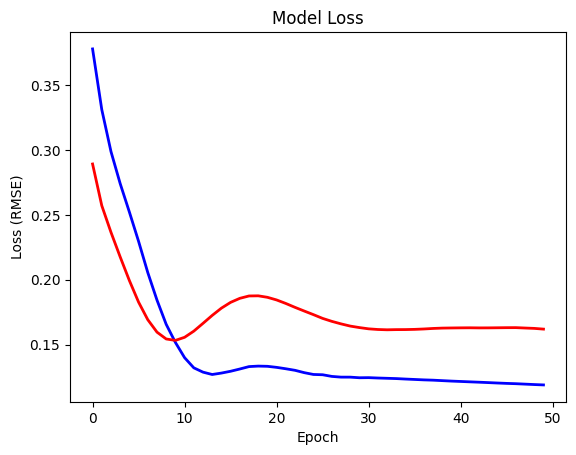

[0.014063856564462185, 0.1068812757730484]


In [ ]:
# Plotar a curva de perda do modelo
loss1 = np.sqrt(history.history['loss'])
val_loss1 = np.sqrt(history.history['val_loss'])

plt.plot(loss1, label='train', color='blue', linewidth=2)
plt.plot(val_loss1, label='test', color='red', linewidth=2)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (RMSE)')
# plt.ylim(0, 50)
# plt.legend(loc='top right')
plt.show()

# Avaliar o modelo nos dados de treinamento
scores = model.evaluate(train_input, train_output, verbose=0)
print(scores)

1/1 [==============================] - 0s 66ms/step
R^2: 0.4212261302120949
MSE: 0.026215119833313028


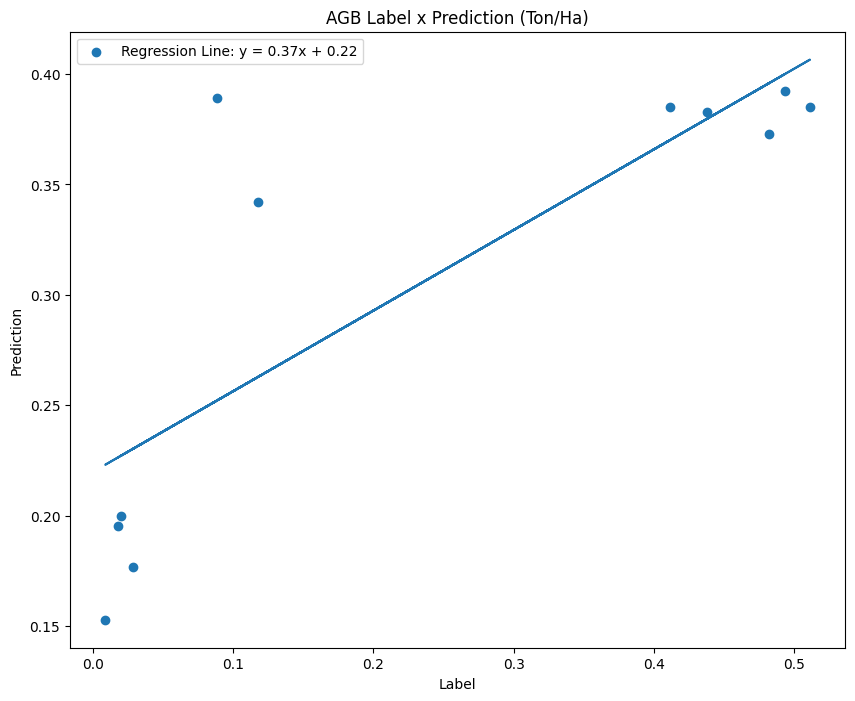

In [ ]:
### Predict test data
# Realizar previsões nos dados de teste.

# Fazer previsões usando o modelo treinado nos dados de entrada de teste e achatar o resultado em um array unidimensional.
prediction = model.predict(test_input).flatten()

# Achatar os rótulos reais (dados de saída de teste) em um array unidimensional.
label = test_output.flatten()

### R2 and RMSE
# Calcular o coeficiente de determinação R^2 e o erro quadrático médio (MSE).

# Calcular o R^2, que mede o quão bem as previsões se ajustam aos dados reais.
r2 = r2_score(label, prediction)

# Calcular o MSE, que é uma medida da qualidade das previsões.
mse = mean_squared_error(label, prediction)

# Imprimir os valores calculados de R^2 e MSE.
print(f'R^2: {r2}\nMSE: {mse}')

### Plot
# Criar um gráfico de dispersão para comparar os rótulos reais e as previsões.
# Criar uma figura com tamanho especificado (10, 8).
plt.figure(figsize=(10, 8))
# Criar um gráfico de dispersão com os rótulos reais no eixo x e as previsões no eixo y.
plt.scatter(label, prediction)

# Ajustar uma linha de regressão linear (y = mx + b) aos pontos de dispersão.
m, b = np.polyfit(label, prediction, 1)

# Plotar a linha de regressão no gráfico de dispersão.
plt.plot(label, m * label + b)

# Adicionar um título ao gráfico.
plt.title('AGB Label x Prediction (Ton/Ha)')

# Rotular os eixos x e y do gráfico.
plt.xlabel('Label')         # Rótulo do eixo x: Label (rótulos reais).
plt.ylabel('Prediction')    # Rótulo do eixo y: Prediction (previsões).

# Adicionar uma legenda ao gráfico mostrando a equação da linha de regressão.
plt.legend(['Regression Line: y = {:.2f}x + {:.2f}'.format(m, b)])

1/1 [==============================] - 0s 29ms/step


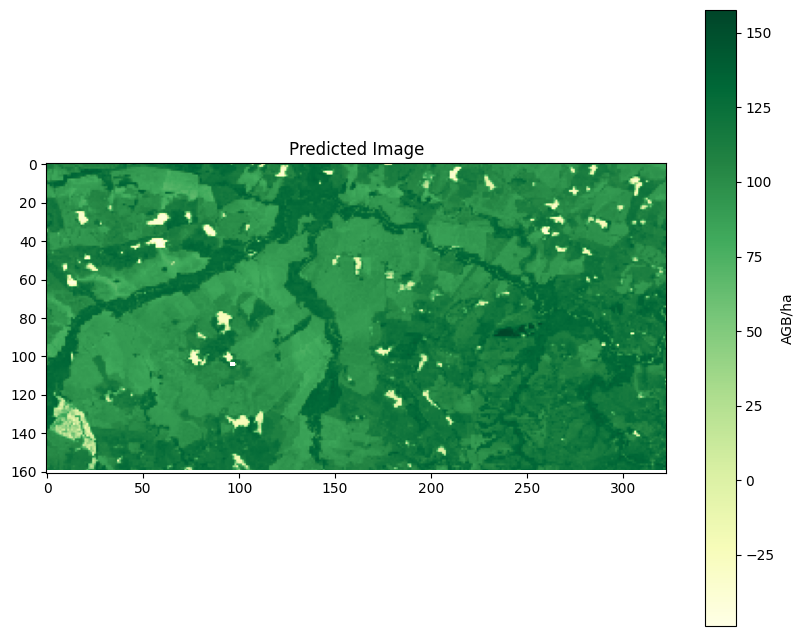

In [ ]:
# Predict image using the model
# Prever uma imagem usando o modelo treinado.

# Inicializar uma lista vazia para armazenar as bandas da imagem usadas como entrada.
image_input = []

# Iterar através das 12 bandas da imagem.
for x in range(12):
  # Ler cada banda (índice de 1 a 12) da imagem e adicioná-la à lista.
  image_input.append(image.read(x + 1))

# Empilhar as bandas da lista para formar um único array numpy tridimensional.
image_input = np.stack(image_input).reshape(12, -1).T

# Predict
# Realizar previsões usando o modelo.

# Usar o modelo para fazer previsões nas bandas da imagem de entrada e multiplicar o resultado por 450.
prediction = model.predict(image_input, batch_size=4096*20) * 450

# Redimensionar as previsões para ter a mesma forma que a imagem original.
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
# Visualizar a imagem de previsão usando a biblioteca rasterio.

# Criar um arquivo de saída para a imagem de previsão.
output_path = 'predicted_image.tif'
with rasterio.open(output_path, 'w', driver='GTiff', width=shape[1], height=shape[0], count=1, dtype='float32', crs=crs, transform=transform) as dst:
    dst.write(prediction, 1)

# Plotar a imagem de previsão usando matplotlib.
plt.figure(figsize=(10,8))
plt.imshow(prediction, cmap='YlGn')
plt.colorbar(label='AGB/ha')
plt.title('Predicted Image')
# plt.xlabel('Column #')
# plt.ylabel('Row #')
plt.show()

#Hyper-parameter fine tuning


In [ ]:
# note: rf_X is the list of features you created in the previous step
# you need to define rf_X

grid_best_loss = 1000
grid_parameter_loss=[]
# define a list with hyperparameters to be tested
for n_estimators,max_depth,min_samples_split, min_samples_leaf in list(itertools.product(np.arange(30,1000),
                                                                                        np.arange(10,100),
                                                                                        np.arange(2,5),
                                                                                       np.arange(1,2))):
    rmse=[]
    for train, val in cross_val(rf_X,y,folds=7,random_state=42):
        model = RandomForestRegressor(random_state=42, n_estimators=n_estimators,
                                      max_depth = max_depth,
                                      min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf)
        model.fit(train[0],train[1].values.flatten())
        preds = model.predict(val[0])
        rmse.append(np.sqrt(np.mean(np.square(preds-val[1].values.flatten()))))

    if np.mean(rmse) < grid_best_loss:
        grid_best_parameters = [n_estimators, max_depth, min_samples_split, min_samples_leaf]
        grid_best_loss = np.mean(rmse)
    grid_parameter_loss.append(np.mean(rmse))

In [ ]:
# print the results of grid search
print ("Random Forest with GridSearch","\n_","\nRMSE:", grid_best_loss ,"\n_","\nn_estimators:", grid_best_parameters[0],
       "\nmax_depth:", grid_best_parameters[1],"\nmin_samples_split:", grid_best_parameters[2],
       "\nmin_samples_leaf:", grid_best_parameters[3])

# Accuracy Assessment


# Model explanation with SHAP

" Ideally, a Machine Learning (ML) model should be highly accurate and simple to interpret. By ”simple to interpret” is intended the ability to expose its performance in an understandable and intuitive way. Unfortunately, the more the model complexity increases, the harder it is to understand how certain values were predicted and which features had contributed more to those predictions. When working with a simple model, the impact that a feature has on the model output is easily interpretable by looking at its weights; whereas, complex models such as ensemble methods or deep networks are not as easy to understand; in this scenario, a model explainer can help interpreting the model results.

In the following cells, the SHapley Additive exPlanations (SHAP) package was used as model explainer. SHAP was created by Lundberg et al. (2020) and, according to its author, its implementation allows for appropriate user trust, provides insights for model improvement, and supports the understanding of the problem being modelled."

In [ ]:
shap.initjs()

In [ ]:
# initialize a model, or use one of the previously created models
# in this example we initialize an XGB model
model_xgb = xgboost.XGBRegressor(random_state=42)
model_xgb.fit(xgb_X, y.values.flatten())

In [ ]:
explainer_xgb = shap.TreeExplainer(model_xgb)
shap_values_xgb = explainer_xgb.shap_values(xgb_X)

In [ ]:
# summarize plot which shoes the effects of all the features on model output
shap.summary_plot(shap_values_xgb, xgb_X)